
# Speech Command Classification with torchaudio



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys
import matplotlib.pyplot as plt
import IPython.display as ipd
import random
import numpy as np
import librosa
import pandas as pd
import torchaudio.models as tm

from random import sample
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from copy import deepcopy
import torch.nn.utils.prune as prune

import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torchvision.models import vision_transformer


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
from torchaudio.datasets import SPEECHCOMMANDS
import os

class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            filepath = os.path.join(self._path, 'training_list.txt')
            self._walker = [w for w in self._walker if w not in excludes]
            
        elif subset == "all":
            self._walker = [w for w in self._walker]



In [ ]:
class WavToSpec(torch.nn.Module):
    def __init__(
        self,
        input_freq=16000,
        resample_freq=16000,
        n_fft=1024,
        n_mel=32,
        stretch_factor=0.8,
    ):
        super().__init__()

        self.spec = torchaudio.transforms.Spectrogram(n_fft=n_fft, power=2)

        self.mel_scale = torchaudio.transforms.MelScale(
            n_mels=n_mel, sample_rate=resample_freq, n_stft=n_fft // 2 + 1)

    def forward(self, waveform: torch.Tensor) -> torch.Tensor:
        spec = self.spec(waveform)
        spec = torch.from_numpy(librosa.power_to_db(spec))

        return spec

In [ ]:
class MelSpectogram(torch.nn.Module):
    def __init__(
        self,
        input_freq=16000,
        resample_freq=16000,
        n_fft=1024,
        n_mel=32,
        stretch_factor=0.8,
    ):
        super().__init__()

        self.spec = torchaudio.transforms.Spectrogram(n_fft=n_fft, power=2)

        self.mel_scale = torchaudio.transforms.MelScale(
            n_mels=n_mel, sample_rate=resample_freq, n_stft=n_fft // 2 + 1)

    def forward(self, waveform: torch.Tensor) -> torch.Tensor:
        spec = self.spec(waveform)

        mel = self.mel_scale(spec)

        return mel

In [ ]:
pipeline_to_mel = MelSpectogram()

In [ ]:
transform = torchaudio.transforms.Resample(orig_freq=16000, new_freq=8000)

In [ ]:
train_set = SubsetSC("training")
test_set = SubsetSC("testing")
valid_set = SubsetSC("validation")
all_set = SubsetSC("all")

100%|██████████| 2.26G/2.26G [01:41<00:00, 23.9MB/s]


In [ ]:
def pad_dataset(dataset,max):
  max = max
  converted_datset = []
  for datum in tqdm(dataset):
    if datum[0].shape[1]<max:
        pad_datum =nn.ConstantPad1d((0, max - datum[0].shape[1]), 0)(datum[0])
        converted_datset.append((transform(pad_datum),datum[1], datum[2],datum[3], datum[4] ))
    else:
      converted_datset.append((transform(datum[0]),datum[1], datum[2],datum[3], datum[4] ))
  return converted_datset

In [ ]:
# train_set_pad = pad_dataset(train_set,16000)
# test_set_pad = pad_dataset(test_set,16000)
# valid_set_pad = pad_dataset(valid_set,16000)

100%|██████████| 9981/9981 [00:52<00:00, 188.46it/s]


In [ ]:
def convert_waveform(dataset,pipeline,max):
  max = max
  converted_datset = []
  for datum in tqdm(dataset):
    if datum[0].shape[1]<max:
        pad_datum =nn.ConstantPad1d((0, max - datum[0].shape[1]), 0)(datum[0])
        converted_datset.append((pipeline(transform(pad_datum)),datum[1], datum[2],datum[3], datum[4] ))
    else:
      converted_datset.append((pipeline(transform(datum[0])),datum[1], datum[2],datum[3], datum[4] ))
  return converted_datset


In [ ]:
train_mel = convert_waveform(train_set,pipeline_to_mel,16000)
test_mel = convert_waveform(test_set,pipeline_to_mel,16000)
valid_mel = convert_waveform(valid_set,pipeline_to_mel,16000)

100%|██████████| 9981/9981 [01:15<00:00, 131.41it/s]


In [ ]:
# labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
labels = ['backward','bed','bird','cat','dog','down','eight','five','follow','forward','four',
          'go','happy','house','learn','left','marvin','nine','no','off','on','one','right',
          'seven','sheila','six','stop','three','tree','two','up','visual','wow','yes','zero']

In [ ]:
def label_to_index(word):
    return torch.tensor(labels.index(word))

def index_to_label(index):
    return labels[index]

# Getting train and test loaders

In [ ]:
def collate_fn(batch):

    tensors, targets = [], []

    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]
    targets = torch.stack(targets)
    tensors = torch.stack(tensors)
    return tensors, targets

In [ ]:
def loaders(batch_size,train_mel,valid_mel,test_mel):
  train_loader = torch.utils.data.DataLoader(
      train_mel,
      batch_size=batch_size,
      shuffle=True,
      num_workers=2,
      pin_memory=True,
      collate_fn = collate_fn
  )

  valid_loader = torch.utils.data.DataLoader(
      valid_mel,
      batch_size=batch_size,
      shuffle=False,
      num_workers=2,
      pin_memory=True,
      collate_fn = collate_fn
  )

  test_loader = torch.utils.data.DataLoader(
      test_mel,
      batch_size=batch_size,
      shuffle=False,
      drop_last=False,
      num_workers=2,
      pin_memory=True,
      collate_fn = collate_fn
  )
  return train_loader,valid_loader,test_loader

# Model Architecture

In [ ]:
class VGGish(nn.Module):
    def __init__(self,num_classes):
        super(VGGish, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2))
        self.embeddings = nn.Sequential(
            nn.Linear(1024, 2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes))

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.embeddings(x)
        return x

In [ ]:
class VGG9(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(VGG9, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(256 * 32 * 32, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x



# WAV2VEC 2.0

https://juliusruseckas.github.io/ml/audio-transformer.html

In [ ]:
class ModelConfig:
    input_dim = 1
    dim = 32
    mlp_dim = 128
    n_transformer_blocks = 8
    heads = 8
    feature_extractor_layers = [(10, 5)] + [(3, 2)] * 4
    pos_kernel_size = 65
    num_classes = len(labels)
    feature_extractor_p_drop = 0.1
    pos_p_drop = 0.1
    attn_p_drop = 0.1
    head_p_drop = 0.1

    def __init__(self, **kwargs):
        for k, v in kwargs.items():
            setattr(self, k, v)
class TransposeLast(nn.Module):
    def forward(self, x):
        return x.transpose(-2, -1)
class ConvBlock(nn.Sequential):
    def __init__(self, input_dim, output_dim, kernel_size, stride, p_drop=0.):
        super().__init__(
            nn.Conv1d(input_dim, output_dim, kernel_size=kernel_size, stride=stride, bias=False),
            nn.Dropout(p_drop),
            TransposeLast(),
            nn.LayerNorm(output_dim),
            TransposeLast(),
            nn.GELU()
        )
class ConvFeatureExtractor(nn.Sequential):
    def __init__(self, cfg):
        dim = cfg.dim
        p_drop = cfg.feature_extractor_p_drop

        layers = []
        in_dim = cfg.input_dim
        for kernel_size, stride in cfg.feature_extractor_layers:
            layers.append(ConvBlock(in_dim, dim, kernel_size, stride, p_drop))
            in_dim = dim
        super().__init__(*layers)

# TRANSFORMER ENCODER
class Residual(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.residual = nn.Sequential(*layers)

    def forward(self, x):
        return x + self.residual(x)
class FeedForward(nn.Sequential):
    def __init__(self, dim, hidden_dim, p_drop=0.):
        super().__init__(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(p_drop),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(p_drop)
        )
class SelfAttention(nn.Module):
    def __init__(self, dim, heads=8, p_drop=0.):
        super().__init__()
        self.heads = heads

        self.to_keys = nn.Linear(dim, dim)
        self.to_queries = nn.Linear(dim, dim)
        self.to_values = nn.Linear(dim, dim)
        self.unifyheads = nn.Linear(dim, dim)

        self.attn_drop = nn.Dropout(p_drop)
        self.resid_drop = nn.Dropout(p_drop)

    def forward(self, x):
        b, t, d = x.size()
        h, d_q = self.heads, d // self.heads

        keys = self.to_keys(x).view(b, t, h, d_q).transpose(1, 2) # move head forward to the batch dim
        queries = self.to_queries(x).view(b, t, h, d_q).transpose(1, 2)
        values = self.to_values(x).view(b, t, h, d_q).transpose(1, 2)

        att = queries @ keys.transpose(-2, -1)
        att = F.softmax(att * d_q**-0.5, dim=-1)
        att = self.attn_drop(att)

        out = att @ values
        out = out.transpose(1, 2).contiguous().view(b, t, d) # move head back
        out = self.unifyheads(out)
        out = self.resid_drop(out)
        return out
class Block(nn.Sequential):
    def __init__(self, dim, heads, mlp_dim, p_drop):
        super().__init__(
            Residual(nn.LayerNorm(dim), SelfAttention(dim, heads, p_drop)),
            Residual(nn.LayerNorm(dim), FeedForward(dim, mlp_dim, p_drop))
        )
class TransformerBlocks(nn.Sequential):
    def __init__(self, dim, depth, heads, mlp_dim, p_drop):
        layers = [Block(dim, heads, mlp_dim, p_drop) for _ in range(depth)]
        super().__init__(*layers)
class PositionEncoding(nn.Module):
    def __init__(self, dim, kernel_size, p_drop=0.):
        super().__init__()
        padding = (kernel_size - 1) // 2
        self.pos_conv = nn.Sequential(
            nn.Conv1d(dim, dim, kernel_size=kernel_size, padding=padding),
            nn.GELU()
        )
        self.dropout = nn.Dropout(p_drop)

    def forward(self, x):
        x = x + self.pos_conv(x)
        x = x.transpose(1, 2)
        x = self.dropout(x)
        return x
class TransformerEncoder(nn.Sequential):
    def __init__(self, cfg):
        dim = cfg.dim
        super().__init__(
            PositionEncoding(dim, cfg.pos_kernel_size, cfg.pos_p_drop),
            TransformerBlocks(dim, cfg.n_transformer_blocks, cfg.heads, cfg.mlp_dim, cfg.attn_p_drop)
        )

# MODEL

class Head(nn.Sequential):
    def __init__(self, dim, hidden_dim, num_classes, p_drop=0.):
        super().__init__(
            nn.LayerNorm(dim),
            TransposeLast(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(p_drop),
            nn.Linear(hidden_dim, num_classes)
        )

class TransformerModel(nn.Sequential):
    def __init__(self, cfg):
        super().__init__(
            ConvFeatureExtractor(cfg),
            TransformerEncoder(cfg),
            Head(cfg.dim, cfg.mlp_dim, cfg.num_classes, cfg.head_p_drop)
        )
        self.reset_parameters()

    def reset_parameters(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=0.02)
                if m.bias is not None: nn.init.zeros_(m.bias)
            elif isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.weight, 1.)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None: nn.init.zeros_(m.bias)

    def separate_parameters(self):
        # biases, and layernorm weights will not be decayed for regularization
        parameters_decay = set()
        parameters_no_decay = set()
        modules_weight_decay = (nn.Linear, nn.Conv1d)
        modules_no_weight_decay = (nn.LayerNorm, )

        for m_name, m in self.named_modules():
            for param_name, param in m.named_parameters():
                full_param_name = f"{m_name}.{param_name}" if m_name else param_name

                if isinstance(m, modules_no_weight_decay):
                    parameters_no_decay.add(full_param_name)
                elif param_name.endswith("bias"):
                    parameters_no_decay.add(full_param_name)
                elif isinstance(m, modules_weight_decay):
                    parameters_decay.add(full_param_name)

        return parameters_decay, parameters_no_decay

In [ ]:
my_conf = ModelConfig()
model_vit = TransformerModel(my_conf)
model_vit.to(device);

# Basic Vision Transformer

In [ ]:
! pip install vit-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 39.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [ ]:
import torch
from torch import nn

from einops import rearrange
from einops.layers.torch import Rearrange

# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

def posemb_sincos_2d(h, w, dim, temperature: int = 10000, dtype = torch.float32):
    y, x = torch.meshgrid(torch.arange(h), torch.arange(w), indexing="ij")
    assert (dim % 4) == 0, "feature dimension must be multiple of 4 for sincos emb"
    omega = torch.arange(dim // 4) / (dim // 4 - 1)
    omega = 1.0 / (temperature ** omega)

    y = y.flatten()[:, None] * omega[None, :]
    x = x.flatten()[:, None] * omega[None, :]
    pe = torch.cat((x.sin(), x.cos(), y.sin(), y.cos()), dim=1)
    return pe.type(dtype)

# classes

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim),
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64):
        super().__init__()
        inner_dim = dim_head *  heads
        self.heads = heads
        self.scale = dim_head ** -0.5
        self.norm = nn.LayerNorm(dim)

        self.attend = nn.Softmax(dim = -1)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)
        self.to_out = nn.Linear(inner_dim, dim, bias = False)

    def forward(self, x):
        x = self.norm(x)

        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Attention(dim, heads = heads, dim_head = dim_head),
                FeedForward(dim, mlp_dim)
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return self.norm(x)

class SimpleViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, channels = 1, dim_head = 64):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        patch_dim = channels * patch_height * patch_width

        self.to_patch_embedding = nn.Sequential(
            Rearrange("b c (h p1) (w p2) -> b (h w) (p1 p2 c)", p1 = patch_height, p2 = patch_width),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim),
            nn.LayerNorm(dim),
        )

        self.pos_embedding = posemb_sincos_2d(
            h = image_height // patch_height,
            w = image_width // patch_width,
            dim = dim,
        )

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim)

        self.pool = "mean"
        self.to_latent = nn.Identity()

        self.linear_head = nn.Linear(dim, num_classes)

    def forward(self, img):
        device = img.device

        x = self.to_patch_embedding(img)
        x += self.pos_embedding.to(device, dtype=x.dtype)

        x = self.transformer(x)
        x = x.mean(dim = 1)

        x = self.to_latent(x)
        return self.linear_head(x)

In [ ]:
model_vit = SimpleViT(
    image_size = 32,
    patch_size = 32,
    num_classes = len(labels),
    dim = 1024,
    depth = 6,
    heads = 16,
    mlp_dim = 2048
)


# Covolover

In [ ]:
conformer = tm.Conformer(input_dim=80,num_heads=4,ffn_dim=128,num_layers=4,depthwise_conv_kernel_size=31)

In [ ]:
torch.ones(size = [1,1,32,32])


## Training and Testing the Network





In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
def evaluate(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in dataloader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = 100 * correct / total
    return accuracy

def evaluate_test(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item()
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    test_loss /= len(test_loader)
    test_accuracy = 100 * correct / total
    return test_loss, test_accuracy

In [ ]:
def train(model, train_loader,valid_loader, test_loader, optimizer, criterion, device, n_epoch, log_interval, seed):
    set_seed(seed)
    best_model = None
    best_accuracy = 0.0
    best_model_epoch = 0
    best_test_accuracy = 0,
    best_test_loss = float('inf'),
    best_valid_accuracy = 0,
    best_valid_loss = float('inf')
    early_stop_accuracy = 0


    losses = []
    accuracies = []

    for epoch in tqdm(range(1, n_epoch + 1)):
      model.train()
      epoch_loss = 0.0

      for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

      accuracy = evaluate(model, train_loader, device)
      accuracies.append(accuracy)

      valid_accuracy = evaluate(model, valid_loader, device)
      if valid_accuracy > best_accuracy:
          best_accuracy = valid_accuracy
          best_model = deepcopy(model)
          best_model_epoch = epoch
          best_test_loss, best_test_accuracy = evaluate_test(best_model, test_loader, criterion, device)
          early_stop_accuracy = accuracy

      epoch_loss /= len(train_loader)
      losses.append(epoch_loss)
      print(f"Epoch: {epoch}/{n_epoch}\tTrain Loss: {epoch_loss:.6f}\tTrain Accuracy: {accuracy:.2f}%")
      test_loss, test_accuracy = evaluate_test(model, test_loader, criterion, device)
      print(f'Test Loss: {test_loss:.6f}, Test Accuracy: {test_accuracy:.2f}%')

    print(f"Best model achieved at epoch: {best_model_epoch}\t Train accuracy: {early_stop_accuracy:.2f}\t Valid accuracy: {best_accuracy:.2f}\t Test accuracy: {best_test_accuracy:.2f}")
    plt.plot(losses)
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    return best_model,accuracies


In [ ]:
# model = VGG9(in_channels =1, num_classes=len(labels))
model = VGGish(num_classes = len(labels))
print(model)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

n = count_parameters(model)
print("Number of parameters: %s" % n)

VGGish(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False

In [ ]:
# train_mel = convert_waveform(train_set,pipeline_to_mel,16000)
# train_loader,valid_loader,test_loader =  loaders(256,train_set_pad,valid_set_pad,test_set_pad)
train_loader,valid_loader,test_loader =  loaders(256,train_mel,valid_mel,test_mel)

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1/40	Train Loss: 3.343563	Train Accuracy: 20.09%


  2%|▎         | 1/40 [00:20<13:07, 20.18s/it]

Test Loss: 2.977130, Test Accuracy: 19.86%
Epoch: 2/40	Train Loss: 2.777954	Train Accuracy: 32.17%


  5%|▌         | 2/40 [00:37<11:44, 18.54s/it]

Test Loss: 2.505171, Test Accuracy: 31.44%
Epoch: 3/40	Train Loss: 2.053890	Train Accuracy: 53.35%


  8%|▊         | 3/40 [00:53<10:50, 17.57s/it]

Test Loss: 1.707672, Test Accuracy: 52.09%
Epoch: 4/40	Train Loss: 1.371783	Train Accuracy: 66.63%


 10%|█         | 4/40 [01:11<10:34, 17.62s/it]

Test Loss: 1.245634, Test Accuracy: 64.43%
Epoch: 5/40	Train Loss: 1.088795	Train Accuracy: 72.85%


 12%|█▎        | 5/40 [01:28<10:12, 17.51s/it]

Test Loss: 1.059291, Test Accuracy: 69.13%
Epoch: 6/40	Train Loss: 0.901421	Train Accuracy: 73.82%


 15%|█▌        | 6/40 [01:47<10:03, 17.74s/it]

Test Loss: 1.055340, Test Accuracy: 69.73%
Epoch: 7/40	Train Loss: 0.782876	Train Accuracy: 78.99%


 18%|█▊        | 7/40 [02:05<09:47, 17.81s/it]

Test Loss: 0.955425, Test Accuracy: 72.19%
Epoch: 8/40	Train Loss: 0.686340	Train Accuracy: 79.39%


 20%|██        | 8/40 [02:22<09:24, 17.64s/it]

Test Loss: 0.985430, Test Accuracy: 72.76%
Epoch: 9/40	Train Loss: 0.632327	Train Accuracy: 82.77%


 22%|██▎       | 9/40 [02:40<09:09, 17.72s/it]

Test Loss: 0.869929, Test Accuracy: 74.49%
Epoch: 10/40	Train Loss: 0.555280	Train Accuracy: 84.67%


 25%|██▌       | 10/40 [02:57<08:46, 17.56s/it]

Test Loss: 0.865020, Test Accuracy: 75.49%
Epoch: 11/40	Train Loss: 0.504953	Train Accuracy: 86.65%


 28%|██▊       | 11/40 [03:15<08:32, 17.68s/it]

Test Loss: 0.852742, Test Accuracy: 76.62%
Epoch: 12/40	Train Loss: 0.471204	Train Accuracy: 87.22%


 30%|███       | 12/40 [03:32<08:13, 17.62s/it]

Test Loss: 0.907388, Test Accuracy: 76.29%
Epoch: 13/40	Train Loss: 0.435144	Train Accuracy: 85.97%


 32%|███▎      | 13/40 [03:49<07:45, 17.25s/it]

Test Loss: 0.966773, Test Accuracy: 75.38%
Epoch: 14/40	Train Loss: 0.412555	Train Accuracy: 88.79%


 35%|███▌      | 14/40 [04:06<07:26, 17.16s/it]

Test Loss: 0.936913, Test Accuracy: 76.15%
Epoch: 15/40	Train Loss: 0.362510	Train Accuracy: 89.39%


 38%|███▊      | 15/40 [04:22<07:01, 16.84s/it]

Test Loss: 1.014768, Test Accuracy: 76.18%
Epoch: 16/40	Train Loss: 0.348034	Train Accuracy: 91.61%


 40%|████      | 16/40 [04:39<06:48, 17.02s/it]

Test Loss: 0.875117, Test Accuracy: 77.28%
Epoch: 17/40	Train Loss: 0.324154	Train Accuracy: 89.26%


 42%|████▎     | 17/40 [04:57<06:32, 17.08s/it]

Test Loss: 1.072377, Test Accuracy: 76.34%
Epoch: 18/40	Train Loss: 0.310720	Train Accuracy: 91.01%


 45%|████▌     | 18/40 [05:13<06:10, 16.84s/it]

Test Loss: 1.041502, Test Accuracy: 75.76%
Epoch: 19/40	Train Loss: 0.288517	Train Accuracy: 93.14%


 48%|████▊     | 19/40 [05:31<06:01, 17.21s/it]

Test Loss: 0.966268, Test Accuracy: 77.67%
Epoch: 20/40	Train Loss: 0.279082	Train Accuracy: 93.02%


 50%|█████     | 20/40 [05:49<05:47, 17.39s/it]

Test Loss: 1.071641, Test Accuracy: 76.65%
Epoch: 21/40	Train Loss: 0.279217	Train Accuracy: 94.05%


 52%|█████▎    | 21/40 [06:06<05:27, 17.22s/it]

Test Loss: 1.114801, Test Accuracy: 77.33%
Epoch: 22/40	Train Loss: 0.284248	Train Accuracy: 92.24%


 55%|█████▌    | 22/40 [06:23<05:09, 17.20s/it]

Test Loss: 1.112589, Test Accuracy: 76.16%
Epoch: 23/40	Train Loss: 0.289259	Train Accuracy: 93.72%


 57%|█████▊    | 23/40 [06:39<04:47, 16.93s/it]

Test Loss: 1.026505, Test Accuracy: 77.26%
Epoch: 24/40	Train Loss: 0.222637	Train Accuracy: 93.10%


 60%|██████    | 24/40 [06:56<04:32, 17.00s/it]

Test Loss: 1.256748, Test Accuracy: 75.63%
Epoch: 25/40	Train Loss: 0.260270	Train Accuracy: 93.48%


 62%|██████▎   | 25/40 [07:13<04:14, 17.00s/it]

Test Loss: 1.159241, Test Accuracy: 76.62%
Epoch: 26/40	Train Loss: 0.221368	Train Accuracy: 94.80%


 65%|██████▌   | 26/40 [07:30<03:58, 17.07s/it]

Test Loss: 1.216020, Test Accuracy: 76.81%
Epoch: 27/40	Train Loss: 0.215570	Train Accuracy: 94.47%


 68%|██████▊   | 27/40 [07:48<03:43, 17.16s/it]

Test Loss: 1.243415, Test Accuracy: 76.60%
Epoch: 28/40	Train Loss: 0.278999	Train Accuracy: 92.04%


 70%|███████   | 28/40 [08:04<03:23, 16.97s/it]

Test Loss: 1.103453, Test Accuracy: 74.67%
Epoch: 29/40	Train Loss: 0.211381	Train Accuracy: 95.22%


 72%|███████▎  | 29/40 [08:21<03:04, 16.75s/it]

Test Loss: 1.393420, Test Accuracy: 77.38%
Epoch: 30/40	Train Loss: 0.190216	Train Accuracy: 94.87%


 75%|███████▌  | 30/40 [08:38<02:48, 16.89s/it]

Test Loss: 1.432826, Test Accuracy: 76.28%
Epoch: 31/40	Train Loss: 0.194459	Train Accuracy: 94.59%


 78%|███████▊  | 31/40 [08:54<02:31, 16.84s/it]

Test Loss: 1.379475, Test Accuracy: 75.67%
Epoch: 32/40	Train Loss: 0.213798	Train Accuracy: 93.57%


 80%|████████  | 32/40 [09:11<02:14, 16.76s/it]

Test Loss: 1.340121, Test Accuracy: 75.88%
Epoch: 33/40	Train Loss: 0.201960	Train Accuracy: 89.49%


 82%|████████▎ | 33/40 [09:28<01:58, 16.92s/it]

Test Loss: 1.155368, Test Accuracy: 73.45%
Epoch: 34/40	Train Loss: 0.240064	Train Accuracy: 94.01%


 85%|████████▌ | 34/40 [09:45<01:40, 16.75s/it]

Test Loss: 1.213887, Test Accuracy: 76.73%
Epoch: 35/40	Train Loss: 0.200088	Train Accuracy: 96.07%


 88%|████████▊ | 35/40 [10:03<01:25, 17.14s/it]

Test Loss: 1.375835, Test Accuracy: 76.89%
Epoch: 36/40	Train Loss: 0.236242	Train Accuracy: 95.20%


 90%|█████████ | 36/40 [10:20<01:08, 17.06s/it]

Test Loss: 1.482182, Test Accuracy: 76.20%
Epoch: 37/40	Train Loss: 0.189432	Train Accuracy: 97.06%


 92%|█████████▎| 37/40 [10:36<00:50, 16.85s/it]

Test Loss: 1.394057, Test Accuracy: 77.14%
Epoch: 38/40	Train Loss: 0.158397	Train Accuracy: 96.36%


 95%|█████████▌| 38/40 [10:53<00:33, 16.93s/it]

Test Loss: 1.457558, Test Accuracy: 77.26%
Epoch: 39/40	Train Loss: 0.154309	Train Accuracy: 97.60%


 98%|█████████▊| 39/40 [11:11<00:17, 17.13s/it]

Test Loss: 1.579266, Test Accuracy: 77.70%
Epoch: 40/40	Train Loss: 0.138386	Train Accuracy: 96.22%


100%|██████████| 40/40 [11:27<00:00, 17.19s/it]

Test Loss: 1.265586, Test Accuracy: 77.06%
Best model achieved at epoch: 39	 Train accuracy: 97.60	 Valid accuracy: 79.06	 Test accuracy: 77.70


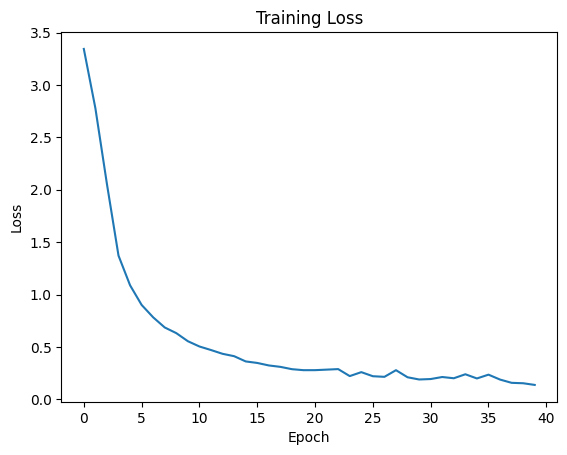

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
criterion = torch.nn.CrossEntropyLoss()
model.to(device)
n_epoch = 40
log_interval = 1
seed = 42
best_model,acc = train(model, train_loader,valid_loader, test_loader, optimizer, criterion, device, n_epoch, log_interval, seed)

In [ ]:
torch.save(best_model.state_dict(), 'SpeechCommands_VGGish.pth')

In [ ]:
df_train, df_test, df_all = mai_logits(model,train_loader,test_loader)

  0%|          | 0/332 [00:00<?, ?it/s]<ipython-input-27-f032b52d8ce3>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train = df_train.append(df_logit_train, ignore_index=True)
100%|██████████| 332/332 [00:07<00:00, 44.56it/s]
<ipython-input-27-f032b52d8ce3>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df_logit_test, ignore_index=True)
<ipython-input-27-f032b52d8ce3>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all = df_train.append(df_test,ignore_index=True)


In [ ]:
df_all.to_csv('SpeechCommands_VGGish_logits.csv',index = False)

# Getting raw outputs for MIA

In [ ]:
all_mel = convert_waveform(all_set,pipeline_to_mel,16000)

100%|██████████| 105829/105829 [08:41<00:00, 203.02it/s]


In [ ]:
all_mel

In [ ]:
def create_membership_inference_dataset(all_mel,seed):
  train, test_valid = train_test_split(all_mel,train_size = 0.5, test_size=0.5, random_state=seed)
  valid, test = train_test_split(test_valid,train_size = 0.5, test_size=0.5, random_state=seed)
  return train,valid,test

In [ ]:
def mai_logits(model, train_loader, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    model.eval()
    df_train = pd.DataFrame()
    df_test = pd.DataFrame()
    df_all = pd.DataFrame()

    # Process training set
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        data, target = data.to(device), target.to(device)
        with torch.no_grad():
            logits_train = model(data)
            logits_softmax = nn.Softmax(dim=1)(logits_train)
            numpy_logits_train = logits_softmax.cpu().numpy()
            df_logit_train = pd.DataFrame(numpy_logits_train)
            df_train = df_train.append(df_logit_train, ignore_index=True)
    df_train['label'] = 0

    # Process test set
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        with torch.no_grad():
            logits_test = model(data)
            logit_test_softmax = nn.Softmax(dim=1)(logits_test)
            numpy_logits_test = logit_test_softmax.cpu().numpy()
            df_logit_test = pd.DataFrame(numpy_logits_test)
            df_test = df_test.append(df_logit_test, ignore_index=True)
    df_test['label'] = 1

    df_all = df_train.append(df_test,ignore_index=True)

    return df_train, df_test, df_all

# MAI

In [ ]:
def membership_inference_attack(all_mel):
  for i in range(10):
    train_set_mia,valid_set_mia,test_set_mia = create_membership_inference_dataset(all_mel,i)
    train_loader_mia,valid_loader_mia,test_loader_mia =  loaders(256,train_set_mia,valid_set_mia,test_set_mia)
    model = VGGish(num_classes = len(labels))

    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum = 0.9)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
    criterion = torch.nn.CrossEntropyLoss()
    model.to(device)
    n_epoch = 50
    log_interval = 1
    patience = 50
    seed = i
    best_model,acc = train(model, train_loader_mia, optimizer, criterion, device, n_epoch, log_interval ,seed, valid_loader_mia, test_loader_mia)

    train_df, test_df, all_df = mai_logits(model, train_loader_mia, test_loader_mia)
    filename = (f"MAI {i}.csv")
    train_df.to_csv(('train' + filename), index = False)
    test_df.to_csv(('test' + filename), index = False)
    all_df.to_csv(filename, index = False)
    print(filename +" saved")



  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1/50	Loss: 3.412893	Accuracy: 18.32%


  2%|▏         | 1/50 [00:16<13:51, 16.97s/it]

Test Loss: 3.081493, Test Accuracy: 18.91%
Epoch: 2/50	Loss: 2.923644	Accuracy: 34.89%


  4%|▍         | 2/50 [00:34<13:36, 17.02s/it]

Test Loss: 2.653704, Test Accuracy: 34.78%
Epoch: 3/50	Loss: 2.427415	Accuracy: 42.81%


  6%|▌         | 3/50 [00:50<13:11, 16.84s/it]

Test Loss: 2.248040, Test Accuracy: 43.19%
Epoch: 4/50	Loss: 1.753163	Accuracy: 61.20%


  8%|▊         | 4/50 [01:07<12:56, 16.89s/it]

Test Loss: 1.379979, Test Accuracy: 61.36%
Epoch: 5/50	Loss: 1.103374	Accuracy: 70.59%


 10%|█         | 5/50 [01:24<12:36, 16.81s/it]

Test Loss: 1.008609, Test Accuracy: 70.75%
Epoch: 6/50	Loss: 0.816998	Accuracy: 75.38%


 12%|█▏        | 6/50 [01:40<12:09, 16.58s/it]

Test Loss: 0.833503, Test Accuracy: 75.33%
Epoch: 7/50	Loss: 0.644419	Accuracy: 75.97%


 14%|█▍        | 7/50 [01:56<11:52, 16.57s/it]

Test Loss: 0.822799, Test Accuracy: 75.69%
Epoch: 8/50	Loss: 0.555858	Accuracy: 80.62%


 16%|█▌        | 8/50 [02:13<11:41, 16.71s/it]

Test Loss: 0.681078, Test Accuracy: 80.52%
Epoch: 9/50	Loss: 0.478135	Accuracy: 81.38%


 18%|█▊        | 9/50 [02:30<11:20, 16.60s/it]

Test Loss: 0.671414, Test Accuracy: 81.32%
Epoch: 10/50	Loss: 0.421649	Accuracy: 80.84%


 20%|██        | 10/50 [02:46<11:03, 16.59s/it]

Test Loss: 0.671414, Test Accuracy: 81.32%
Epoch: 11/50	Loss: 0.372020	Accuracy: 82.33%


 22%|██▏       | 11/50 [03:03<10:50, 16.69s/it]

Test Loss: 0.710270, Test Accuracy: 81.82%
Epoch: 12/50	Loss: 0.341521	Accuracy: 81.17%


 24%|██▍       | 12/50 [03:20<10:29, 16.57s/it]

Test Loss: 0.710270, Test Accuracy: 81.82%
Epoch: 13/50	Loss: 0.331902	Accuracy: 81.12%


 26%|██▌       | 13/50 [03:36<10:12, 16.55s/it]

Test Loss: 0.710270, Test Accuracy: 81.82%
Epoch: 14/50	Loss: 0.287270	Accuracy: 82.73%


 28%|██▊       | 14/50 [03:53<10:00, 16.67s/it]

Test Loss: 0.711835, Test Accuracy: 82.26%
Epoch: 15/50	Loss: 0.249696	Accuracy: 83.17%


 30%|███       | 15/50 [04:09<09:40, 16.58s/it]

Test Loss: 0.724863, Test Accuracy: 82.80%
Epoch: 16/50	Loss: 0.224238	Accuracy: 83.73%


 32%|███▏      | 16/50 [04:26<09:22, 16.54s/it]

Test Loss: 0.764939, Test Accuracy: 83.67%
Epoch: 17/50	Loss: 0.218346	Accuracy: 82.92%


 34%|███▍      | 17/50 [04:43<09:09, 16.65s/it]

Test Loss: 0.764939, Test Accuracy: 83.67%
Epoch: 18/50	Loss: 0.181744	Accuracy: 83.18%


 36%|███▌      | 18/50 [04:59<08:50, 16.57s/it]

Test Loss: 0.764939, Test Accuracy: 83.67%
Epoch: 19/50	Loss: 0.216726	Accuracy: 84.07%


 38%|███▊      | 19/50 [05:16<08:33, 16.55s/it]

Test Loss: 0.778810, Test Accuracy: 83.86%
Epoch: 20/50	Loss: 0.164888	Accuracy: 83.74%


 40%|████      | 20/50 [05:33<08:20, 16.67s/it]

Test Loss: 0.778810, Test Accuracy: 83.86%
Epoch: 21/50	Loss: 0.166261	Accuracy: 82.74%


 42%|████▏     | 21/50 [05:49<08:00, 16.55s/it]

Test Loss: 0.778810, Test Accuracy: 83.86%
Epoch: 22/50	Loss: 0.125893	Accuracy: 84.20%


 44%|████▍     | 22/50 [06:05<07:41, 16.50s/it]

Test Loss: 0.831753, Test Accuracy: 83.88%
Epoch: 23/50	Loss: 0.102850	Accuracy: 83.86%


 46%|████▌     | 23/50 [06:22<07:29, 16.66s/it]

Test Loss: 0.831753, Test Accuracy: 83.88%
Epoch: 24/50	Loss: 0.104437	Accuracy: 84.33%


 48%|████▊     | 24/50 [06:39<07:15, 16.75s/it]

Test Loss: 0.902811, Test Accuracy: 84.29%
Epoch: 25/50	Loss: 0.121087	Accuracy: 84.19%


 50%|█████     | 25/50 [06:56<06:55, 16.62s/it]

Test Loss: 0.902811, Test Accuracy: 84.29%
Epoch: 26/50	Loss: 0.118841	Accuracy: 82.61%


 52%|█████▏    | 26/50 [07:13<06:41, 16.72s/it]

Test Loss: 0.902811, Test Accuracy: 84.29%
Epoch: 27/50	Loss: 0.112476	Accuracy: 84.60%


 54%|█████▍    | 27/50 [07:29<06:23, 16.67s/it]

Test Loss: 0.847668, Test Accuracy: 84.31%
Epoch: 28/50	Loss: 0.092752	Accuracy: 83.04%


 56%|█████▌    | 28/50 [07:45<06:04, 16.56s/it]

Test Loss: 0.847668, Test Accuracy: 84.31%
Epoch: 29/50	Loss: 0.078116	Accuracy: 83.72%


 58%|█████▊    | 29/50 [08:02<05:49, 16.63s/it]

Test Loss: 0.847668, Test Accuracy: 84.31%
Epoch: 30/50	Loss: 0.074250	Accuracy: 84.62%


 60%|██████    | 30/50 [08:19<05:32, 16.61s/it]

Test Loss: 1.062899, Test Accuracy: 84.41%
Epoch: 31/50	Loss: 0.060146	Accuracy: 84.02%


 62%|██████▏   | 31/50 [08:35<05:13, 16.52s/it]

Test Loss: 1.062899, Test Accuracy: 84.41%
Epoch: 32/50	Loss: 0.066718	Accuracy: 82.53%


 64%|██████▍   | 32/50 [08:52<04:58, 16.57s/it]

Test Loss: 1.062899, Test Accuracy: 84.41%
Epoch: 33/50	Loss: 0.073828	Accuracy: 84.40%


 66%|██████▌   | 33/50 [09:09<04:42, 16.64s/it]

Test Loss: 1.062899, Test Accuracy: 84.41%
Epoch: 34/50	Loss: 0.120368	Accuracy: 83.89%


 68%|██████▊   | 34/50 [09:25<04:27, 16.72s/it]

Test Loss: 1.062899, Test Accuracy: 84.41%
Epoch: 35/50	Loss: 0.061406	Accuracy: 84.91%


 70%|███████   | 35/50 [09:42<04:11, 16.74s/it]

Test Loss: 1.088104, Test Accuracy: 84.61%
Epoch: 36/50	Loss: 0.069064	Accuracy: 84.41%


 72%|███████▏  | 36/50 [09:59<03:54, 16.72s/it]

Test Loss: 1.088104, Test Accuracy: 84.61%
Epoch: 37/50	Loss: 0.050670	Accuracy: 84.43%


 74%|███████▍  | 37/50 [10:15<03:35, 16.61s/it]

Test Loss: 1.088104, Test Accuracy: 84.61%
Epoch: 38/50	Loss: 0.042146	Accuracy: 84.52%


 76%|███████▌  | 38/50 [10:32<03:19, 16.66s/it]

Test Loss: 1.088104, Test Accuracy: 84.61%
Epoch: 39/50	Loss: 0.055903	Accuracy: 83.65%


 78%|███████▊  | 39/50 [10:49<03:03, 16.66s/it]

Test Loss: 1.088104, Test Accuracy: 84.61%
Epoch: 40/50	Loss: 0.060897	Accuracy: 84.31%


 80%|████████  | 40/50 [11:05<02:45, 16.53s/it]

Test Loss: 1.088104, Test Accuracy: 84.61%
Epoch: 41/50	Loss: 0.043640	Accuracy: 84.27%


 82%|████████▏ | 41/50 [11:22<02:29, 16.60s/it]

Test Loss: 1.088104, Test Accuracy: 84.61%
Epoch: 42/50	Loss: 0.056643	Accuracy: 84.71%


 84%|████████▍ | 42/50 [11:38<02:13, 16.65s/it]

Test Loss: 1.088104, Test Accuracy: 84.61%
Epoch: 43/50	Loss: 0.050067	Accuracy: 84.48%


 86%|████████▌ | 43/50 [11:55<01:55, 16.53s/it]

Test Loss: 1.088104, Test Accuracy: 84.61%
Epoch: 44/50	Loss: 0.029576	Accuracy: 84.91%


 88%|████████▊ | 44/50 [12:12<01:39, 16.63s/it]

Test Loss: 1.088104, Test Accuracy: 84.61%
Epoch: 45/50	Loss: 0.053437	Accuracy: 84.46%


 90%|█████████ | 45/50 [12:29<01:23, 16.74s/it]

Test Loss: 1.088104, Test Accuracy: 84.61%
Epoch: 46/50	Loss: 0.057227	Accuracy: 84.11%


 92%|█████████▏| 46/50 [12:45<01:06, 16.59s/it]

Test Loss: 1.088104, Test Accuracy: 84.61%
Epoch: 47/50	Loss: 0.044516	Accuracy: 84.12%


 94%|█████████▍| 47/50 [13:01<00:49, 16.54s/it]

Test Loss: 1.088104, Test Accuracy: 84.61%
Epoch: 48/50	Loss: 0.046466	Accuracy: 83.42%


 96%|█████████▌| 48/50 [13:18<00:33, 16.67s/it]

Test Loss: 1.088104, Test Accuracy: 84.61%
Epoch: 49/50	Loss: 0.047620	Accuracy: 84.80%


 98%|█████████▊| 49/50 [13:34<00:16, 16.55s/it]

Test Loss: 1.088104, Test Accuracy: 84.61%
Epoch: 50/50	Loss: 0.028021	Accuracy: 84.73%


100%|██████████| 50/50 [13:51<00:00, 16.63s/it]

Test Loss: 1.088104, Test Accuracy: 84.61%


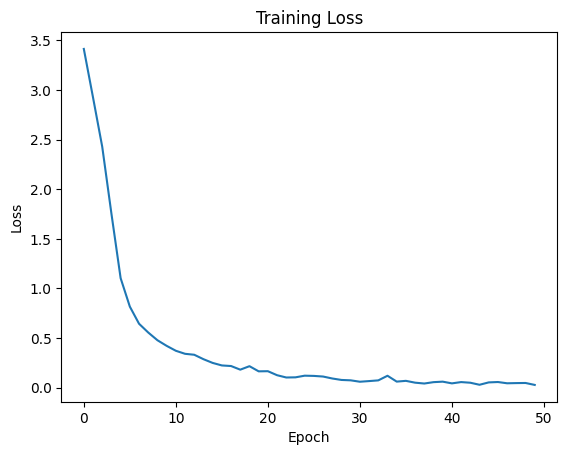

  0%|          | 0/207 [00:00<?, ?it/s]<ipython-input-27-f032b52d8ce3>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train = df_train.append(df_logit_train, ignore_index=True)
100%|██████████| 207/207 [00:05<00:00, 39.18it/s]
<ipython-input-27-f032b52d8ce3>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df_logit_test, ignore_index=True)
<ipython-input-27-f032b52d8ce3>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all = df_train.append(df_test,ignore_index=True)


MAI 0.csv saved


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1/50	Loss: 3.442772	Accuracy: 14.56%


  2%|▏         | 1/50 [00:16<13:47, 16.88s/it]

Test Loss: 3.192447, Test Accuracy: 14.51%
Epoch: 2/50	Loss: 2.963712	Accuracy: 29.47%


  4%|▍         | 2/50 [00:33<13:20, 16.69s/it]

Test Loss: 2.737128, Test Accuracy: 29.67%
Epoch: 3/50	Loss: 2.427955	Accuracy: 43.76%


  6%|▌         | 3/50 [00:49<12:57, 16.54s/it]

Test Loss: 2.213773, Test Accuracy: 44.33%
Epoch: 4/50	Loss: 1.796079	Accuracy: 59.31%


  8%|▊         | 4/50 [01:06<12:52, 16.79s/it]

Test Loss: 1.560396, Test Accuracy: 59.37%
Epoch: 5/50	Loss: 1.249354	Accuracy: 66.85%


 10%|█         | 5/50 [01:23<12:37, 16.83s/it]

Test Loss: 1.133613, Test Accuracy: 67.90%
Epoch: 6/50	Loss: 0.907263	Accuracy: 74.52%


 12%|█▏        | 6/50 [01:40<12:12, 16.65s/it]

Test Loss: 0.889110, Test Accuracy: 74.71%
Epoch: 7/50	Loss: 0.744361	Accuracy: 78.01%


 14%|█▍        | 7/50 [01:56<11:54, 16.62s/it]

Test Loss: 0.752715, Test Accuracy: 78.09%
Epoch: 8/50	Loss: 0.615826	Accuracy: 79.50%


 16%|█▌        | 8/50 [02:13<11:45, 16.80s/it]

Test Loss: 0.729776, Test Accuracy: 79.32%
Epoch: 9/50	Loss: 0.520726	Accuracy: 80.47%


 18%|█▊        | 9/50 [02:30<11:24, 16.69s/it]

Test Loss: 0.727437, Test Accuracy: 80.14%
Epoch: 10/50	Loss: 0.481168	Accuracy: 81.94%


 20%|██        | 10/50 [02:46<11:03, 16.59s/it]

Test Loss: 0.645787, Test Accuracy: 81.68%
Epoch: 11/50	Loss: 0.418212	Accuracy: 82.37%


 22%|██▏       | 11/50 [03:03<10:51, 16.71s/it]

Test Loss: 0.671821, Test Accuracy: 82.04%
Epoch: 12/50	Loss: 0.359086	Accuracy: 83.35%


 24%|██▍       | 12/50 [03:20<10:39, 16.82s/it]

Test Loss: 0.662359, Test Accuracy: 83.21%
Epoch: 13/50	Loss: 0.339134	Accuracy: 81.81%


 26%|██▌       | 13/50 [03:37<10:16, 16.67s/it]

Test Loss: 0.662359, Test Accuracy: 83.21%
Epoch: 14/50	Loss: 0.290913	Accuracy: 83.02%


 28%|██▊       | 14/50 [03:53<09:59, 16.65s/it]

Test Loss: 0.662359, Test Accuracy: 83.21%
Epoch: 15/50	Loss: 0.272625	Accuracy: 83.58%


 30%|███       | 15/50 [04:10<09:47, 16.79s/it]

Test Loss: 0.653669, Test Accuracy: 83.48%
Epoch: 16/50	Loss: 0.257399	Accuracy: 83.10%


 32%|███▏      | 16/50 [04:27<09:30, 16.79s/it]

Test Loss: 0.653669, Test Accuracy: 83.48%
Epoch: 17/50	Loss: 0.275024	Accuracy: 83.07%


 34%|███▍      | 17/50 [04:44<09:10, 16.68s/it]

Test Loss: 0.653669, Test Accuracy: 83.48%
Epoch: 18/50	Loss: 0.229607	Accuracy: 82.72%


 36%|███▌      | 18/50 [05:00<08:53, 16.67s/it]

Test Loss: 0.653669, Test Accuracy: 83.48%
Epoch: 19/50	Loss: 0.209401	Accuracy: 84.22%


 38%|███▊      | 19/50 [05:17<08:41, 16.82s/it]

Test Loss: 0.789721, Test Accuracy: 84.04%
Epoch: 20/50	Loss: 0.175970	Accuracy: 80.55%


 40%|████      | 20/50 [05:34<08:21, 16.72s/it]

Test Loss: 0.789721, Test Accuracy: 84.04%
Epoch: 21/50	Loss: 0.216810	Accuracy: 81.88%


 42%|████▏     | 21/50 [05:50<08:02, 16.62s/it]

Test Loss: 0.789721, Test Accuracy: 84.04%
Epoch: 22/50	Loss: 0.246072	Accuracy: 82.21%


 44%|████▍     | 22/50 [06:07<07:47, 16.69s/it]

Test Loss: 0.789721, Test Accuracy: 84.04%
Epoch: 23/50	Loss: 0.154475	Accuracy: 83.99%


 46%|████▌     | 23/50 [06:24<07:35, 16.85s/it]

Test Loss: 0.789721, Test Accuracy: 84.04%
Epoch: 24/50	Loss: 0.135880	Accuracy: 83.57%


 48%|████▊     | 24/50 [06:41<07:16, 16.77s/it]

Test Loss: 0.789721, Test Accuracy: 84.04%
Epoch: 25/50	Loss: 0.149171	Accuracy: 84.91%


 50%|█████     | 25/50 [06:57<06:56, 16.65s/it]

Test Loss: 0.823297, Test Accuracy: 84.83%
Epoch: 26/50	Loss: 0.134274	Accuracy: 84.81%


 52%|█████▏    | 26/50 [07:14<06:43, 16.82s/it]

Test Loss: 0.823297, Test Accuracy: 84.83%
Epoch: 27/50	Loss: 0.130417	Accuracy: 84.48%


 54%|█████▍    | 27/50 [07:32<06:30, 16.99s/it]

Test Loss: 0.823297, Test Accuracy: 84.83%
Epoch: 28/50	Loss: 0.101148	Accuracy: 84.16%


 56%|█████▌    | 28/50 [07:48<06:09, 16.80s/it]

Test Loss: 0.823297, Test Accuracy: 84.83%
Epoch: 29/50	Loss: 0.113864	Accuracy: 83.54%


 58%|█████▊    | 29/50 [08:05<05:52, 16.78s/it]

Test Loss: 0.823297, Test Accuracy: 84.83%
Epoch: 30/50	Loss: 0.158016	Accuracy: 83.80%


 60%|██████    | 30/50 [08:22<05:36, 16.84s/it]

Test Loss: 0.823297, Test Accuracy: 84.83%
Epoch: 31/50	Loss: 0.142464	Accuracy: 84.59%


 62%|██████▏   | 31/50 [08:38<05:17, 16.69s/it]

Test Loss: 0.823297, Test Accuracy: 84.83%
Epoch: 32/50	Loss: 0.114969	Accuracy: 84.35%


 64%|██████▍   | 32/50 [08:55<04:58, 16.60s/it]

Test Loss: 0.823297, Test Accuracy: 84.83%
Epoch: 33/50	Loss: 0.113351	Accuracy: 84.95%


 66%|██████▌   | 33/50 [09:12<04:44, 16.74s/it]

Test Loss: 0.875072, Test Accuracy: 84.63%
Epoch: 34/50	Loss: 0.092229	Accuracy: 84.03%


 68%|██████▊   | 34/50 [09:29<04:30, 16.88s/it]

Test Loss: 0.875072, Test Accuracy: 84.63%
Epoch: 35/50	Loss: 0.074959	Accuracy: 84.84%


 70%|███████   | 35/50 [09:45<04:10, 16.71s/it]

Test Loss: 0.875072, Test Accuracy: 84.63%
Epoch: 36/50	Loss: 0.073729	Accuracy: 85.07%


 72%|███████▏  | 36/50 [10:02<03:53, 16.69s/it]

Test Loss: 1.083918, Test Accuracy: 84.61%
Epoch: 37/50	Loss: 0.058775	Accuracy: 84.53%


 74%|███████▍  | 37/50 [10:19<03:38, 16.81s/it]

Test Loss: 1.083918, Test Accuracy: 84.61%
Epoch: 38/50	Loss: 0.053279	Accuracy: 84.27%


 76%|███████▌  | 38/50 [10:35<03:19, 16.66s/it]

Test Loss: 1.083918, Test Accuracy: 84.61%
Epoch: 39/50	Loss: 0.077587	Accuracy: 85.13%


 78%|███████▊  | 39/50 [10:52<03:02, 16.56s/it]

Test Loss: 1.042308, Test Accuracy: 85.15%
Epoch: 40/50	Loss: 0.054836	Accuracy: 85.56%


 80%|████████  | 40/50 [11:09<02:47, 16.74s/it]

Test Loss: 0.998424, Test Accuracy: 85.18%
Epoch: 41/50	Loss: 0.045894	Accuracy: 84.62%


 82%|████████▏ | 41/50 [11:26<02:30, 16.75s/it]

Test Loss: 0.998424, Test Accuracy: 85.18%
Epoch: 42/50	Loss: 0.051339	Accuracy: 84.02%


 84%|████████▍ | 42/50 [11:42<02:12, 16.62s/it]

Test Loss: 0.998424, Test Accuracy: 85.18%
Epoch: 43/50	Loss: 0.060559	Accuracy: 84.71%


 86%|████████▌ | 43/50 [11:58<01:56, 16.58s/it]

Test Loss: 0.998424, Test Accuracy: 85.18%
Epoch: 44/50	Loss: 0.061290	Accuracy: 85.23%


 88%|████████▊ | 44/50 [12:16<01:40, 16.82s/it]

Test Loss: 0.998424, Test Accuracy: 85.18%
Epoch: 45/50	Loss: 0.095581	Accuracy: 83.00%


 90%|█████████ | 45/50 [12:32<01:23, 16.70s/it]

Test Loss: 0.998424, Test Accuracy: 85.18%
Epoch: 46/50	Loss: 0.102643	Accuracy: 85.50%


 92%|█████████▏| 46/50 [12:48<01:06, 16.58s/it]

Test Loss: 0.998424, Test Accuracy: 85.18%
Epoch: 47/50	Loss: 0.049874	Accuracy: 84.70%


 94%|█████████▍| 47/50 [13:05<00:49, 16.63s/it]

Test Loss: 0.998424, Test Accuracy: 85.18%
Epoch: 48/50	Loss: 0.045644	Accuracy: 84.70%


 96%|█████████▌| 48/50 [13:22<00:33, 16.78s/it]

Test Loss: 0.998424, Test Accuracy: 85.18%
Epoch: 49/50	Loss: 0.047172	Accuracy: 85.14%


 98%|█████████▊| 49/50 [13:39<00:16, 16.65s/it]

Test Loss: 0.998424, Test Accuracy: 85.18%
Epoch: 50/50	Loss: 0.058779	Accuracy: 85.27%


100%|██████████| 50/50 [13:55<00:00, 16.71s/it]

Test Loss: 0.998424, Test Accuracy: 85.18%


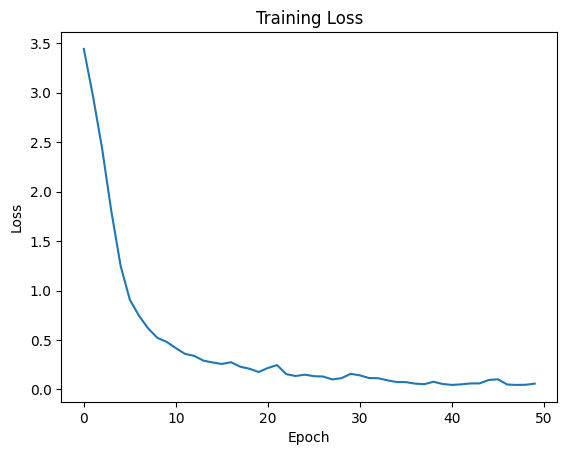

  0%|          | 0/207 [00:00<?, ?it/s]<ipython-input-27-f032b52d8ce3>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train = df_train.append(df_logit_train, ignore_index=True)
100%|██████████| 207/207 [00:05<00:00, 38.25it/s]
<ipython-input-27-f032b52d8ce3>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df_logit_test, ignore_index=True)
<ipython-input-27-f032b52d8ce3>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all = df_train.append(df_test,ignore_index=True)


MAI 1.csv saved


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1/50	Loss: 3.551511	Accuracy: 4.70%


  2%|▏         | 1/50 [00:17<13:59, 17.13s/it]

Test Loss: 3.506669, Test Accuracy: 4.43%
Epoch: 2/50	Loss: 3.382396	Accuracy: 13.18%


  4%|▍         | 2/50 [00:33<13:27, 16.82s/it]

Test Loss: 3.177112, Test Accuracy: 13.18%
Epoch: 3/50	Loss: 3.088121	Accuracy: 23.51%


  6%|▌         | 3/50 [00:50<13:05, 16.71s/it]

Test Loss: 2.873460, Test Accuracy: 24.00%
Epoch: 4/50	Loss: 2.693670	Accuracy: 36.98%


  8%|▊         | 4/50 [01:06<12:41, 16.55s/it]

Test Loss: 2.408024, Test Accuracy: 37.27%
Epoch: 5/50	Loss: 2.085652	Accuracy: 54.79%


 10%|█         | 5/50 [01:23<12:30, 16.69s/it]

Test Loss: 1.644826, Test Accuracy: 55.07%
Epoch: 6/50	Loss: 1.474495	Accuracy: 63.76%


 12%|█▏        | 6/50 [01:40<12:22, 16.89s/it]

Test Loss: 1.247868, Test Accuracy: 63.94%
Epoch: 7/50	Loss: 1.034024	Accuracy: 70.73%


 14%|█▍        | 7/50 [01:57<11:59, 16.72s/it]

Test Loss: 1.000024, Test Accuracy: 70.95%
Epoch: 8/50	Loss: 0.835205	Accuracy: 76.07%


 16%|█▌        | 8/50 [02:13<11:38, 16.62s/it]

Test Loss: 0.885912, Test Accuracy: 75.80%
Epoch: 9/50	Loss: 0.682323	Accuracy: 77.68%


 18%|█▊        | 9/50 [02:30<11:25, 16.73s/it]

Test Loss: 0.758728, Test Accuracy: 77.97%
Epoch: 10/50	Loss: 0.584491	Accuracy: 78.46%


 20%|██        | 10/50 [02:47<11:15, 16.89s/it]

Test Loss: 0.728583, Test Accuracy: 78.91%
Epoch: 11/50	Loss: 0.506604	Accuracy: 80.51%


 22%|██▏       | 11/50 [03:04<10:52, 16.73s/it]

Test Loss: 0.717090, Test Accuracy: 80.63%
Epoch: 12/50	Loss: 0.457925	Accuracy: 80.14%


 24%|██▍       | 12/50 [03:20<10:33, 16.67s/it]

Test Loss: 0.717090, Test Accuracy: 80.63%
Epoch: 13/50	Loss: 0.410474	Accuracy: 82.56%


 26%|██▌       | 13/50 [03:37<10:22, 16.82s/it]

Test Loss: 0.658466, Test Accuracy: 82.53%
Epoch: 14/50	Loss: 0.369516	Accuracy: 81.64%


 28%|██▊       | 14/50 [03:55<10:10, 16.96s/it]

Test Loss: 0.658466, Test Accuracy: 82.53%
Epoch: 15/50	Loss: 0.342840	Accuracy: 78.98%


 30%|███       | 15/50 [04:11<09:48, 16.82s/it]

Test Loss: 0.658466, Test Accuracy: 82.53%
Epoch: 16/50	Loss: 0.352586	Accuracy: 83.03%


 32%|███▏      | 16/50 [04:28<09:27, 16.70s/it]

Test Loss: 0.641204, Test Accuracy: 83.46%
Epoch: 17/50	Loss: 0.268857	Accuracy: 81.98%


 34%|███▍      | 17/50 [04:44<09:11, 16.72s/it]

Test Loss: 0.641204, Test Accuracy: 83.46%
Epoch: 18/50	Loss: 0.257772	Accuracy: 83.39%


 36%|███▌      | 18/50 [05:02<09:00, 16.90s/it]

Test Loss: 0.699780, Test Accuracy: 83.22%
Epoch: 19/50	Loss: 0.243536	Accuracy: 81.64%


 38%|███▊      | 19/50 [05:18<08:41, 16.84s/it]

Test Loss: 0.699780, Test Accuracy: 83.22%
Epoch: 20/50	Loss: 0.222821	Accuracy: 81.65%


 40%|████      | 20/50 [05:35<08:21, 16.71s/it]

Test Loss: 0.699780, Test Accuracy: 83.22%
Epoch: 21/50	Loss: 0.198337	Accuracy: 83.88%


 42%|████▏     | 21/50 [05:51<08:03, 16.68s/it]

Test Loss: 0.663812, Test Accuracy: 84.00%
Epoch: 22/50	Loss: 0.199121	Accuracy: 82.58%


 44%|████▍     | 22/50 [06:09<07:53, 16.92s/it]

Test Loss: 0.663812, Test Accuracy: 84.00%
Epoch: 23/50	Loss: 0.208166	Accuracy: 83.66%


 46%|████▌     | 23/50 [06:26<07:37, 16.96s/it]

Test Loss: 0.663812, Test Accuracy: 84.00%
Epoch: 24/50	Loss: 0.187630	Accuracy: 83.23%


 48%|████▊     | 24/50 [06:42<07:16, 16.80s/it]

Test Loss: 0.663812, Test Accuracy: 84.00%
Epoch: 25/50	Loss: 0.143858	Accuracy: 83.33%


 50%|█████     | 25/50 [06:59<06:57, 16.72s/it]

Test Loss: 0.663812, Test Accuracy: 84.00%
Epoch: 26/50	Loss: 0.155529	Accuracy: 84.79%


 52%|█████▏    | 26/50 [07:16<06:45, 16.91s/it]

Test Loss: 0.926795, Test Accuracy: 84.83%
Epoch: 27/50	Loss: 0.125012	Accuracy: 83.58%


 54%|█████▍    | 27/50 [07:33<06:28, 16.91s/it]

Test Loss: 0.926795, Test Accuracy: 84.83%
Epoch: 28/50	Loss: 0.104373	Accuracy: 83.67%


 56%|█████▌    | 28/50 [07:50<06:08, 16.76s/it]

Test Loss: 0.926795, Test Accuracy: 84.83%
Epoch: 29/50	Loss: 0.124753	Accuracy: 82.71%


 58%|█████▊    | 29/50 [08:06<05:49, 16.66s/it]

Test Loss: 0.926795, Test Accuracy: 84.83%
Epoch: 30/50	Loss: 0.130297	Accuracy: 83.32%


 60%|██████    | 30/50 [08:23<05:36, 16.84s/it]

Test Loss: 0.926795, Test Accuracy: 84.83%
Epoch: 31/50	Loss: 0.081910	Accuracy: 84.16%


 62%|██████▏   | 31/50 [08:40<05:21, 16.91s/it]

Test Loss: 0.926795, Test Accuracy: 84.83%
Epoch: 32/50	Loss: 0.095421	Accuracy: 83.38%


 64%|██████▍   | 32/50 [08:57<05:01, 16.77s/it]

Test Loss: 0.926795, Test Accuracy: 84.83%
Epoch: 33/50	Loss: 0.089698	Accuracy: 84.25%


 66%|██████▌   | 33/50 [09:13<04:44, 16.73s/it]

Test Loss: 0.926795, Test Accuracy: 84.83%
Epoch: 34/50	Loss: 0.099573	Accuracy: 84.35%


 68%|██████▊   | 34/50 [09:30<04:27, 16.75s/it]

Test Loss: 0.926795, Test Accuracy: 84.83%
Epoch: 35/50	Loss: 0.071936	Accuracy: 83.90%


 70%|███████   | 35/50 [09:47<04:13, 16.92s/it]

Test Loss: 0.926795, Test Accuracy: 84.83%
Epoch: 36/50	Loss: 0.076816	Accuracy: 82.11%


 72%|███████▏  | 36/50 [10:04<03:55, 16.82s/it]

Test Loss: 0.926795, Test Accuracy: 84.83%
Epoch: 37/50	Loss: 0.061859	Accuracy: 83.58%


 74%|███████▍  | 37/50 [10:20<03:37, 16.70s/it]

Test Loss: 0.926795, Test Accuracy: 84.83%
Epoch: 38/50	Loss: 0.091619	Accuracy: 82.97%


 76%|███████▌  | 38/50 [10:37<03:20, 16.69s/it]

Test Loss: 0.926795, Test Accuracy: 84.83%
Epoch: 39/50	Loss: 0.088486	Accuracy: 84.18%


 78%|███████▊  | 39/50 [10:55<03:06, 16.93s/it]

Test Loss: 0.926795, Test Accuracy: 84.83%
Epoch: 40/50	Loss: 0.058704	Accuracy: 84.45%


 80%|████████  | 40/50 [11:11<02:48, 16.89s/it]

Test Loss: 0.926795, Test Accuracy: 84.83%
Epoch: 41/50	Loss: 0.065889	Accuracy: 83.95%


 82%|████████▏ | 41/50 [11:28<02:30, 16.77s/it]

Test Loss: 0.926795, Test Accuracy: 84.83%
Epoch: 42/50	Loss: 0.059102	Accuracy: 83.22%


 84%|████████▍ | 42/50 [11:45<02:13, 16.73s/it]

Test Loss: 0.926795, Test Accuracy: 84.83%
Epoch: 43/50	Loss: 0.073577	Accuracy: 83.07%


 86%|████████▌ | 43/50 [12:02<01:59, 17.04s/it]

Test Loss: 0.926795, Test Accuracy: 84.83%
Epoch: 44/50	Loss: 0.098039	Accuracy: 83.03%


 88%|████████▊ | 44/50 [12:19<01:41, 16.97s/it]

Test Loss: 0.926795, Test Accuracy: 84.83%
Epoch: 45/50	Loss: 0.093164	Accuracy: 83.78%


 90%|█████████ | 45/50 [12:36<01:24, 16.80s/it]

Test Loss: 0.926795, Test Accuracy: 84.83%
Epoch: 46/50	Loss: 0.114535	Accuracy: 83.84%


 92%|█████████▏| 46/50 [12:52<01:06, 16.74s/it]

Test Loss: 0.926795, Test Accuracy: 84.83%
Epoch: 47/50	Loss: 0.065756	Accuracy: 84.27%


 94%|█████████▍| 47/50 [13:10<00:50, 16.94s/it]

Test Loss: 0.926795, Test Accuracy: 84.83%
Epoch: 48/50	Loss: 0.042980	Accuracy: 83.88%


 96%|█████████▌| 48/50 [13:26<00:33, 16.93s/it]

Test Loss: 0.926795, Test Accuracy: 84.83%
Epoch: 49/50	Loss: 0.059427	Accuracy: 84.25%


 98%|█████████▊| 49/50 [13:43<00:16, 16.77s/it]

Test Loss: 0.926795, Test Accuracy: 84.83%
Epoch: 50/50	Loss: 0.047412	Accuracy: 83.85%


100%|██████████| 50/50 [14:00<00:00, 16.80s/it]

Test Loss: 0.926795, Test Accuracy: 84.83%


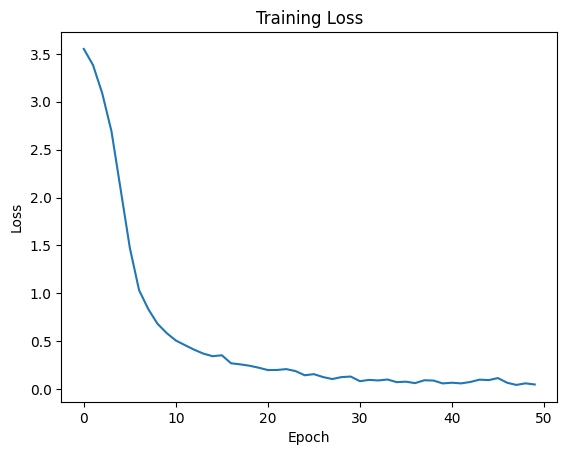

  0%|          | 0/207 [00:00<?, ?it/s]<ipython-input-27-f032b52d8ce3>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train = df_train.append(df_logit_train, ignore_index=True)
100%|██████████| 207/207 [00:06<00:00, 34.07it/s]
<ipython-input-27-f032b52d8ce3>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df_logit_test, ignore_index=True)
<ipython-input-27-f032b52d8ce3>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all = df_train.append(df_test,ignore_index=True)


MAI 2.csv saved


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1/50	Loss: 3.537674	Accuracy: 7.79%


  2%|▏         | 1/50 [00:17<14:40, 17.97s/it]

Test Loss: 3.446238, Test Accuracy: 7.72%
Epoch: 2/50	Loss: 3.206226	Accuracy: 20.21%


  4%|▍         | 2/50 [00:36<14:51, 18.58s/it]

Test Loss: 3.029579, Test Accuracy: 20.28%
Epoch: 3/50	Loss: 2.767801	Accuracy: 35.93%


  6%|▌         | 3/50 [00:54<14:06, 18.02s/it]

Test Loss: 2.524736, Test Accuracy: 35.67%
Epoch: 4/50	Loss: 2.195213	Accuracy: 49.28%


  8%|▊         | 4/50 [01:11<13:26, 17.52s/it]

Test Loss: 1.963905, Test Accuracy: 49.10%
Epoch: 5/50	Loss: 1.532684	Accuracy: 65.93%


 10%|█         | 5/50 [01:27<12:54, 17.22s/it]

Test Loss: 1.250115, Test Accuracy: 65.28%
Epoch: 6/50	Loss: 1.028673	Accuracy: 72.31%


 12%|█▏        | 6/50 [01:44<12:33, 17.12s/it]

Test Loss: 0.984109, Test Accuracy: 71.69%
Epoch: 7/50	Loss: 0.810359	Accuracy: 75.30%


 14%|█▍        | 7/50 [02:02<12:29, 17.44s/it]

Test Loss: 0.860949, Test Accuracy: 74.63%
Epoch: 8/50	Loss: 0.656793	Accuracy: 79.50%


 16%|█▌        | 8/50 [02:20<12:10, 17.39s/it]

Test Loss: 0.723298, Test Accuracy: 78.64%
Epoch: 9/50	Loss: 0.555731	Accuracy: 80.83%


 18%|█▊        | 9/50 [02:36<11:45, 17.21s/it]

Test Loss: 0.670302, Test Accuracy: 80.48%
Epoch: 10/50	Loss: 0.467659	Accuracy: 79.91%


 20%|██        | 10/50 [02:53<11:23, 17.10s/it]

Test Loss: 0.670302, Test Accuracy: 80.48%
Epoch: 11/50	Loss: 0.430971	Accuracy: 81.78%


 22%|██▏       | 11/50 [03:11<11:09, 17.16s/it]

Test Loss: 0.655756, Test Accuracy: 81.26%
Epoch: 12/50	Loss: 0.410390	Accuracy: 82.22%


 24%|██▍       | 12/50 [03:29<11:02, 17.43s/it]

Test Loss: 0.653517, Test Accuracy: 82.09%
Epoch: 13/50	Loss: 0.347962	Accuracy: 82.86%


 26%|██▌       | 13/50 [03:46<10:41, 17.35s/it]

Test Loss: 0.649825, Test Accuracy: 82.40%
Epoch: 14/50	Loss: 0.295888	Accuracy: 82.11%


 28%|██▊       | 14/50 [04:03<10:19, 17.21s/it]

Test Loss: 0.649825, Test Accuracy: 82.40%
Epoch: 15/50	Loss: 0.270056	Accuracy: 81.93%


 30%|███       | 15/50 [04:19<09:57, 17.07s/it]

Test Loss: 0.649825, Test Accuracy: 82.40%
Epoch: 16/50	Loss: 0.247890	Accuracy: 83.49%


 32%|███▏      | 16/50 [04:36<09:36, 16.97s/it]

Test Loss: 0.727248, Test Accuracy: 83.36%
Epoch: 17/50	Loss: 0.210104	Accuracy: 82.92%


 34%|███▍      | 17/50 [04:54<09:24, 17.12s/it]

Test Loss: 0.727248, Test Accuracy: 83.36%
Epoch: 18/50	Loss: 0.211028	Accuracy: 83.97%


 36%|███▌      | 18/50 [05:11<09:14, 17.34s/it]

Test Loss: 0.681941, Test Accuracy: 83.14%
Epoch: 19/50	Loss: 0.190854	Accuracy: 82.43%


 38%|███▊      | 19/50 [05:29<08:58, 17.37s/it]

Test Loss: 0.681941, Test Accuracy: 83.14%
Epoch: 20/50	Loss: 0.181750	Accuracy: 83.19%


 40%|████      | 20/50 [05:46<08:35, 17.17s/it]

Test Loss: 0.681941, Test Accuracy: 83.14%
Epoch: 21/50	Loss: 0.179446	Accuracy: 83.21%


 42%|████▏     | 21/50 [06:02<08:12, 16.99s/it]

Test Loss: 0.681941, Test Accuracy: 83.14%
Epoch: 22/50	Loss: 0.177770	Accuracy: 84.34%


 44%|████▍     | 22/50 [06:20<07:58, 17.10s/it]

Test Loss: 0.769706, Test Accuracy: 83.87%
Epoch: 23/50	Loss: 0.162691	Accuracy: 82.83%


 46%|████▌     | 23/50 [06:37<07:47, 17.31s/it]

Test Loss: 0.769706, Test Accuracy: 83.87%
Epoch: 24/50	Loss: 0.138790	Accuracy: 84.42%


 48%|████▊     | 24/50 [06:55<07:30, 17.33s/it]

Test Loss: 0.857519, Test Accuracy: 83.93%
Epoch: 25/50	Loss: 0.149941	Accuracy: 83.99%


 50%|█████     | 25/50 [07:11<07:08, 17.15s/it]

Test Loss: 0.857519, Test Accuracy: 83.93%
Epoch: 26/50	Loss: 0.142291	Accuracy: 84.20%


 52%|█████▏    | 26/50 [07:28<06:48, 17.02s/it]

Test Loss: 0.857519, Test Accuracy: 83.93%
Epoch: 27/50	Loss: 0.104031	Accuracy: 84.31%


 54%|█████▍    | 27/50 [07:45<06:31, 17.03s/it]

Test Loss: 0.857519, Test Accuracy: 83.93%
Epoch: 28/50	Loss: 0.105490	Accuracy: 83.92%


 56%|█████▌    | 28/50 [08:03<06:18, 17.20s/it]

Test Loss: 0.857519, Test Accuracy: 83.93%
Epoch: 29/50	Loss: 0.104112	Accuracy: 83.37%


 58%|█████▊    | 29/50 [08:20<06:01, 17.22s/it]

Test Loss: 0.857519, Test Accuracy: 83.93%
Epoch: 30/50	Loss: 0.099049	Accuracy: 83.49%


 60%|██████    | 30/50 [08:37<05:39, 16.99s/it]

Test Loss: 0.857519, Test Accuracy: 83.93%
Epoch: 31/50	Loss: 0.087654	Accuracy: 84.20%


 62%|██████▏   | 31/50 [08:53<05:20, 16.85s/it]

Test Loss: 0.857519, Test Accuracy: 83.93%
Epoch: 32/50	Loss: 0.063817	Accuracy: 84.76%


 64%|██████▍   | 32/50 [09:10<05:04, 16.92s/it]

Test Loss: 0.953167, Test Accuracy: 84.56%
Epoch: 33/50	Loss: 0.056637	Accuracy: 84.48%


 66%|██████▌   | 33/50 [09:28<04:50, 17.06s/it]

Test Loss: 0.953167, Test Accuracy: 84.56%
Epoch: 34/50	Loss: 0.101504	Accuracy: 84.16%


 68%|██████▊   | 34/50 [09:45<04:33, 17.07s/it]

Test Loss: 0.953167, Test Accuracy: 84.56%
Epoch: 35/50	Loss: 0.067454	Accuracy: 84.96%


 70%|███████   | 35/50 [10:01<04:13, 16.88s/it]

Test Loss: 0.984834, Test Accuracy: 84.45%
Epoch: 36/50	Loss: 0.063916	Accuracy: 84.23%


 72%|███████▏  | 36/50 [10:18<03:54, 16.77s/it]

Test Loss: 0.984834, Test Accuracy: 84.45%
Epoch: 37/50	Loss: 0.048633	Accuracy: 84.84%


 74%|███████▍  | 37/50 [10:34<03:38, 16.78s/it]

Test Loss: 0.984834, Test Accuracy: 84.45%
Epoch: 38/50	Loss: 0.061330	Accuracy: 83.57%


 76%|███████▌  | 38/50 [10:52<03:23, 16.97s/it]

Test Loss: 0.984834, Test Accuracy: 84.45%
Epoch: 39/50	Loss: 0.088634	Accuracy: 84.23%


 78%|███████▊  | 39/50 [11:09<03:07, 17.00s/it]

Test Loss: 0.984834, Test Accuracy: 84.45%
Epoch: 40/50	Loss: 0.063041	Accuracy: 84.68%


 80%|████████  | 40/50 [11:25<02:48, 16.84s/it]

Test Loss: 0.984834, Test Accuracy: 84.45%
Epoch: 41/50	Loss: 0.047698	Accuracy: 84.70%


 82%|████████▏ | 41/50 [11:42<02:30, 16.74s/it]

Test Loss: 0.984834, Test Accuracy: 84.45%
Epoch: 42/50	Loss: 0.041108	Accuracy: 84.16%


 84%|████████▍ | 42/50 [11:59<02:16, 17.01s/it]

Test Loss: 0.984834, Test Accuracy: 84.45%
Epoch: 43/50	Loss: 0.029553	Accuracy: 85.55%


 86%|████████▌ | 43/50 [12:17<02:00, 17.18s/it]

Test Loss: 1.170639, Test Accuracy: 85.23%
Epoch: 44/50	Loss: 0.028099	Accuracy: 84.91%


 88%|████████▊ | 44/50 [12:34<01:42, 17.08s/it]

Test Loss: 1.170639, Test Accuracy: 85.23%
Epoch: 45/50	Loss: 0.037328	Accuracy: 85.19%


 90%|█████████ | 45/50 [12:50<01:24, 16.92s/it]

Test Loss: 1.170639, Test Accuracy: 85.23%
Epoch: 46/50	Loss: 0.029223	Accuracy: 85.59%


 92%|█████████▏| 46/50 [13:07<01:07, 16.80s/it]

Test Loss: 1.241908, Test Accuracy: 85.26%
Epoch: 47/50	Loss: 0.028561	Accuracy: 84.16%


 94%|█████████▍| 47/50 [13:24<00:50, 16.97s/it]

Test Loss: 1.241908, Test Accuracy: 85.26%
Epoch: 48/50	Loss: 0.048643	Accuracy: 84.63%


 96%|█████████▌| 48/50 [13:42<00:34, 17.17s/it]

Test Loss: 1.241908, Test Accuracy: 85.26%
Epoch: 49/50	Loss: 0.041579	Accuracy: 85.42%


 98%|█████████▊| 49/50 [13:59<00:17, 17.01s/it]

Test Loss: 1.241908, Test Accuracy: 85.26%
Epoch: 50/50	Loss: 0.032282	Accuracy: 84.88%


100%|██████████| 50/50 [14:15<00:00, 17.11s/it]

Test Loss: 1.241908, Test Accuracy: 85.26%


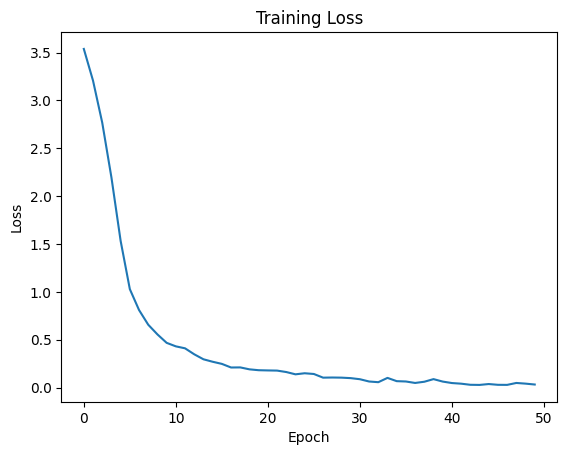

  0%|          | 0/207 [00:00<?, ?it/s]<ipython-input-27-f032b52d8ce3>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train = df_train.append(df_logit_train, ignore_index=True)
100%|██████████| 207/207 [00:05<00:00, 36.18it/s]
<ipython-input-27-f032b52d8ce3>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df_logit_test, ignore_index=True)
<ipython-input-27-f032b52d8ce3>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all = df_train.append(df_test,ignore_index=True)


MAI 3.csv saved


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1/50	Loss: 3.377349	Accuracy: 17.34%


  2%|▏         | 1/50 [00:18<14:46, 18.09s/it]

Test Loss: 3.097079, Test Accuracy: 17.31%
Epoch: 2/50	Loss: 2.890410	Accuracy: 36.24%


  4%|▍         | 2/50 [00:35<14:21, 17.95s/it]

Test Loss: 2.553361, Test Accuracy: 36.38%
Epoch: 3/50	Loss: 2.345499	Accuracy: 46.17%


  6%|▌         | 3/50 [00:53<13:48, 17.63s/it]

Test Loss: 2.126724, Test Accuracy: 46.52%
Epoch: 4/50	Loss: 1.662842	Accuracy: 64.04%


  8%|▊         | 4/50 [01:09<13:12, 17.23s/it]

Test Loss: 1.282839, Test Accuracy: 64.35%
Epoch: 5/50	Loss: 1.051080	Accuracy: 73.01%


 10%|█         | 5/50 [01:26<12:44, 16.99s/it]

Test Loss: 0.933561, Test Accuracy: 73.46%
Epoch: 6/50	Loss: 0.783910	Accuracy: 74.12%


 12%|█▏        | 6/50 [01:42<12:21, 16.86s/it]

Test Loss: 0.888100, Test Accuracy: 74.38%
Epoch: 7/50	Loss: 0.628655	Accuracy: 79.42%


 14%|█▍        | 7/50 [01:59<12:06, 16.90s/it]

Test Loss: 0.710540, Test Accuracy: 79.55%
Epoch: 8/50	Loss: 0.530371	Accuracy: 79.60%


 16%|█▌        | 8/50 [02:17<11:59, 17.14s/it]

Test Loss: 0.769157, Test Accuracy: 80.22%
Epoch: 9/50	Loss: 0.460440	Accuracy: 81.85%


 18%|█▊        | 9/50 [02:34<11:45, 17.20s/it]

Test Loss: 0.650524, Test Accuracy: 82.18%
Epoch: 10/50	Loss: 0.390789	Accuracy: 82.28%


 20%|██        | 10/50 [02:51<11:23, 17.08s/it]

Test Loss: 0.657038, Test Accuracy: 82.49%
Epoch: 11/50	Loss: 0.348809	Accuracy: 82.45%


 22%|██▏       | 11/50 [03:09<11:12, 17.24s/it]

Test Loss: 0.642886, Test Accuracy: 82.84%
Epoch: 12/50	Loss: 0.328798	Accuracy: 81.82%


 24%|██▍       | 12/50 [03:26<10:51, 17.14s/it]

Test Loss: 0.642886, Test Accuracy: 82.84%
Epoch: 13/50	Loss: 0.282654	Accuracy: 82.83%


 26%|██▌       | 13/50 [03:43<10:39, 17.28s/it]

Test Loss: 0.672675, Test Accuracy: 83.15%
Epoch: 14/50	Loss: 0.307335	Accuracy: 83.48%


 28%|██▊       | 14/50 [04:01<10:28, 17.45s/it]

Test Loss: 0.634956, Test Accuracy: 83.57%
Epoch: 15/50	Loss: 0.254103	Accuracy: 83.09%


 30%|███       | 15/50 [04:18<10:06, 17.32s/it]

Test Loss: 0.634956, Test Accuracy: 83.57%
Epoch: 16/50	Loss: 0.206661	Accuracy: 84.54%


 32%|███▏      | 16/50 [04:35<09:41, 17.11s/it]

Test Loss: 0.636081, Test Accuracy: 84.24%
Epoch: 17/50	Loss: 0.195673	Accuracy: 83.10%


 34%|███▍      | 17/50 [04:51<09:19, 16.94s/it]

Test Loss: 0.636081, Test Accuracy: 84.24%
Epoch: 18/50	Loss: 0.176102	Accuracy: 82.81%


 36%|███▌      | 18/50 [05:08<09:02, 16.95s/it]

Test Loss: 0.636081, Test Accuracy: 84.24%
Epoch: 19/50	Loss: 0.151341	Accuracy: 82.46%


 38%|███▊      | 19/50 [05:26<08:53, 17.21s/it]

Test Loss: 0.636081, Test Accuracy: 84.24%
Epoch: 20/50	Loss: 0.184821	Accuracy: 84.03%


 40%|████      | 20/50 [05:43<08:37, 17.23s/it]

Test Loss: 0.636081, Test Accuracy: 84.24%
Epoch: 21/50	Loss: 0.128472	Accuracy: 84.11%


 42%|████▏     | 21/50 [06:01<08:25, 17.43s/it]

Test Loss: 0.636081, Test Accuracy: 84.24%
Epoch: 22/50	Loss: 0.149888	Accuracy: 82.61%


 44%|████▍     | 22/50 [06:18<08:01, 17.19s/it]

Test Loss: 0.636081, Test Accuracy: 84.24%
Epoch: 23/50	Loss: 0.225286	Accuracy: 82.68%


 46%|████▌     | 23/50 [06:35<07:39, 17.03s/it]

Test Loss: 0.636081, Test Accuracy: 84.24%
Epoch: 24/50	Loss: 0.169260	Accuracy: 83.52%


 48%|████▊     | 24/50 [06:52<07:22, 17.00s/it]

Test Loss: 0.636081, Test Accuracy: 84.24%
Epoch: 25/50	Loss: 0.128703	Accuracy: 84.22%


 50%|█████     | 25/50 [07:09<07:10, 17.21s/it]

Test Loss: 0.636081, Test Accuracy: 84.24%
Epoch: 26/50	Loss: 0.095523	Accuracy: 84.17%


 52%|█████▏    | 26/50 [07:27<06:53, 17.24s/it]

Test Loss: 0.636081, Test Accuracy: 84.24%
Epoch: 27/50	Loss: 0.112220	Accuracy: 85.19%


 54%|█████▍    | 27/50 [07:43<06:32, 17.07s/it]

Test Loss: 0.860689, Test Accuracy: 85.31%
Epoch: 28/50	Loss: 0.086031	Accuracy: 84.59%


 56%|█████▌    | 28/50 [08:00<06:12, 16.92s/it]

Test Loss: 0.860689, Test Accuracy: 85.31%
Epoch: 29/50	Loss: 0.092812	Accuracy: 83.48%


 58%|█████▊    | 29/50 [08:16<05:53, 16.83s/it]

Test Loss: 0.860689, Test Accuracy: 85.31%
Epoch: 30/50	Loss: 0.095944	Accuracy: 82.80%


 60%|██████    | 30/50 [08:33<05:37, 16.88s/it]

Test Loss: 0.860689, Test Accuracy: 85.31%
Epoch: 31/50	Loss: 0.071839	Accuracy: 84.55%


 62%|██████▏   | 31/50 [08:52<05:32, 17.47s/it]

Test Loss: 0.860689, Test Accuracy: 85.31%
Epoch: 32/50	Loss: 0.073326	Accuracy: 85.03%


 64%|██████▍   | 32/50 [09:10<05:13, 17.41s/it]

Test Loss: 0.860689, Test Accuracy: 85.31%
Epoch: 33/50	Loss: 0.068195	Accuracy: 84.94%


 66%|██████▌   | 33/50 [09:26<04:52, 17.21s/it]

Test Loss: 0.860689, Test Accuracy: 85.31%
Epoch: 34/50	Loss: 0.055989	Accuracy: 84.44%


 68%|██████▊   | 34/50 [09:43<04:32, 17.04s/it]

Test Loss: 0.860689, Test Accuracy: 85.31%
Epoch: 35/50	Loss: 0.049210	Accuracy: 84.36%


 70%|███████   | 35/50 [10:00<04:13, 16.90s/it]

Test Loss: 0.860689, Test Accuracy: 85.31%
Epoch: 36/50	Loss: 0.053742	Accuracy: 84.78%


 72%|███████▏  | 36/50 [10:16<03:56, 16.90s/it]

Test Loss: 0.860689, Test Accuracy: 85.31%
Epoch: 37/50	Loss: 0.084601	Accuracy: 82.71%


 74%|███████▍  | 37/50 [10:34<03:42, 17.11s/it]

Test Loss: 0.860689, Test Accuracy: 85.31%
Epoch: 38/50	Loss: 0.102078	Accuracy: 84.76%


 76%|███████▌  | 38/50 [10:51<03:26, 17.18s/it]

Test Loss: 0.860689, Test Accuracy: 85.31%
Epoch: 39/50	Loss: 0.058184	Accuracy: 85.29%


 78%|███████▊  | 39/50 [11:08<03:07, 17.03s/it]

Test Loss: 0.961959, Test Accuracy: 85.27%
Epoch: 40/50	Loss: 0.055243	Accuracy: 85.17%


 80%|████████  | 40/50 [11:25<02:48, 16.89s/it]

Test Loss: 0.961959, Test Accuracy: 85.27%
Epoch: 41/50	Loss: 0.035045	Accuracy: 85.27%


 82%|████████▏ | 41/50 [11:43<02:34, 17.21s/it]

Test Loss: 0.961959, Test Accuracy: 85.27%
Epoch: 42/50	Loss: 0.030729	Accuracy: 85.51%


 84%|████████▍ | 42/50 [12:00<02:18, 17.33s/it]

Test Loss: 0.959657, Test Accuracy: 85.82%
Epoch: 43/50	Loss: 0.025979	Accuracy: 84.59%


 86%|████████▌ | 43/50 [12:18<02:02, 17.46s/it]

Test Loss: 0.959657, Test Accuracy: 85.82%
Epoch: 44/50	Loss: 0.027533	Accuracy: 84.44%


 88%|████████▊ | 44/50 [12:35<01:43, 17.29s/it]

Test Loss: 0.959657, Test Accuracy: 85.82%
Epoch: 45/50	Loss: 0.055483	Accuracy: 85.22%


 90%|█████████ | 45/50 [12:52<01:25, 17.10s/it]

Test Loss: 0.959657, Test Accuracy: 85.82%
Epoch: 46/50	Loss: 0.052752	Accuracy: 84.94%


 92%|█████████▏| 46/50 [13:08<01:07, 16.94s/it]

Test Loss: 0.959657, Test Accuracy: 85.82%
Epoch: 47/50	Loss: 0.041083	Accuracy: 84.42%


 94%|█████████▍| 47/50 [13:25<00:50, 16.94s/it]

Test Loss: 0.959657, Test Accuracy: 85.82%
Epoch: 48/50	Loss: 0.033819	Accuracy: 85.38%


 96%|█████████▌| 48/50 [13:43<00:34, 17.17s/it]

Test Loss: 0.959657, Test Accuracy: 85.82%
Epoch: 49/50	Loss: 0.040456	Accuracy: 84.90%


 98%|█████████▊| 49/50 [14:00<00:17, 17.19s/it]

Test Loss: 0.959657, Test Accuracy: 85.82%
Epoch: 50/50	Loss: 0.037359	Accuracy: 85.17%


100%|██████████| 50/50 [14:17<00:00, 17.15s/it]

Test Loss: 0.959657, Test Accuracy: 85.82%


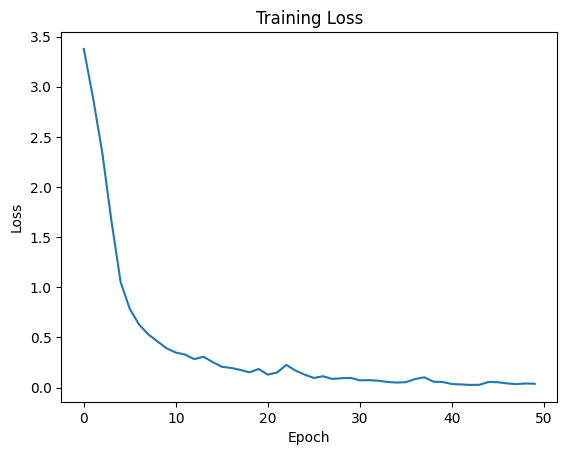

  0%|          | 0/207 [00:00<?, ?it/s]<ipython-input-27-f032b52d8ce3>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train = df_train.append(df_logit_train, ignore_index=True)
100%|██████████| 207/207 [00:04<00:00, 41.97it/s]
<ipython-input-27-f032b52d8ce3>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df_logit_test, ignore_index=True)
<ipython-input-27-f032b52d8ce3>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all = df_train.append(df_test,ignore_index=True)


MAI 4.csv saved


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1/50	Loss: 3.557258	Accuracy: 3.67%


  2%|▏         | 1/50 [00:16<13:29, 16.53s/it]

Test Loss: 3.509566, Test Accuracy: 3.82%
Epoch: 2/50	Loss: 3.496014	Accuracy: 7.33%


  4%|▍         | 2/50 [00:33<13:28, 16.84s/it]

Test Loss: 3.465964, Test Accuracy: 6.89%
Epoch: 3/50	Loss: 3.311912	Accuracy: 17.12%


  6%|▌         | 3/50 [00:51<13:29, 17.22s/it]

Test Loss: 3.041519, Test Accuracy: 17.05%
Epoch: 4/50	Loss: 2.878479	Accuracy: 32.62%


  8%|▊         | 4/50 [01:09<13:23, 17.47s/it]

Test Loss: 2.664270, Test Accuracy: 32.93%
Epoch: 5/50	Loss: 2.381186	Accuracy: 43.35%


 10%|█         | 5/50 [01:26<13:01, 17.36s/it]

Test Loss: 2.098407, Test Accuracy: 43.19%
Epoch: 6/50	Loss: 1.758556	Accuracy: 57.43%


 12%|█▏        | 6/50 [01:42<12:31, 17.07s/it]

Test Loss: 1.552319, Test Accuracy: 57.25%
Epoch: 7/50	Loss: 1.248155	Accuracy: 66.00%


 14%|█▍        | 7/50 [01:59<12:06, 16.89s/it]

Test Loss: 1.207467, Test Accuracy: 66.10%
Epoch: 8/50	Loss: 1.005577	Accuracy: 72.51%


 16%|█▌        | 8/50 [02:15<11:44, 16.77s/it]

Test Loss: 0.973840, Test Accuracy: 72.32%
Epoch: 9/50	Loss: 0.806824	Accuracy: 73.87%


 18%|█▊        | 9/50 [02:32<11:24, 16.69s/it]

Test Loss: 0.893150, Test Accuracy: 73.94%
Epoch: 10/50	Loss: 0.691646	Accuracy: 77.74%


 20%|██        | 10/50 [02:49<11:10, 16.77s/it]

Test Loss: 0.782532, Test Accuracy: 78.01%
Epoch: 11/50	Loss: 0.588428	Accuracy: 79.79%


 22%|██▏       | 11/50 [03:06<11:00, 16.94s/it]

Test Loss: 0.718471, Test Accuracy: 80.00%
Epoch: 12/50	Loss: 0.522916	Accuracy: 80.47%


 24%|██▍       | 12/50 [03:23<10:48, 17.08s/it]

Test Loss: 0.715526, Test Accuracy: 80.57%
Epoch: 13/50	Loss: 0.484575	Accuracy: 80.95%


 26%|██▌       | 13/50 [03:41<10:40, 17.31s/it]

Test Loss: 0.668678, Test Accuracy: 81.03%
Epoch: 14/50	Loss: 0.454238	Accuracy: 81.87%


 28%|██▊       | 14/50 [03:59<10:21, 17.28s/it]

Test Loss: 0.679083, Test Accuracy: 82.30%
Epoch: 15/50	Loss: 0.392754	Accuracy: 81.59%


 30%|███       | 15/50 [04:15<09:59, 17.13s/it]

Test Loss: 0.679083, Test Accuracy: 82.30%
Epoch: 16/50	Loss: 0.343228	Accuracy: 80.77%


 32%|███▏      | 16/50 [04:32<09:36, 16.96s/it]

Test Loss: 0.679083, Test Accuracy: 82.30%
Epoch: 17/50	Loss: 0.369784	Accuracy: 82.57%


 34%|███▍      | 17/50 [04:48<09:15, 16.83s/it]

Test Loss: 0.716983, Test Accuracy: 82.51%
Epoch: 18/50	Loss: 0.304039	Accuracy: 82.02%


 36%|███▌      | 18/50 [05:05<08:55, 16.73s/it]

Test Loss: 0.716983, Test Accuracy: 82.51%
Epoch: 19/50	Loss: 0.285856	Accuracy: 82.13%


 38%|███▊      | 19/50 [05:22<08:40, 16.80s/it]

Test Loss: 0.716983, Test Accuracy: 82.51%
Epoch: 20/50	Loss: 0.253805	Accuracy: 79.62%


 40%|████      | 20/50 [05:40<08:32, 17.07s/it]

Test Loss: 0.716983, Test Accuracy: 82.51%
Epoch: 21/50	Loss: 0.230651	Accuracy: 83.29%


 42%|████▏     | 21/50 [05:58<08:23, 17.35s/it]

Test Loss: 0.692073, Test Accuracy: 83.07%
Epoch: 22/50	Loss: 0.216284	Accuracy: 83.03%


 44%|████▍     | 22/50 [06:15<08:03, 17.26s/it]

Test Loss: 0.692073, Test Accuracy: 83.07%
Epoch: 23/50	Loss: 0.205616	Accuracy: 83.34%


 46%|████▌     | 23/50 [06:31<07:39, 17.03s/it]

Test Loss: 0.778848, Test Accuracy: 83.48%
Epoch: 24/50	Loss: 0.234834	Accuracy: 81.97%


 48%|████▊     | 24/50 [06:48<07:18, 16.85s/it]

Test Loss: 0.778848, Test Accuracy: 83.48%
Epoch: 25/50	Loss: 0.176115	Accuracy: 82.65%


 50%|█████     | 25/50 [07:04<06:58, 16.73s/it]

Test Loss: 0.778848, Test Accuracy: 83.48%
Epoch: 26/50	Loss: 0.167561	Accuracy: 82.82%


 52%|█████▏    | 26/50 [07:21<06:44, 16.84s/it]

Test Loss: 0.778848, Test Accuracy: 83.48%
Epoch: 27/50	Loss: 0.150617	Accuracy: 83.00%


 54%|█████▍    | 27/50 [07:39<06:32, 17.09s/it]

Test Loss: 0.778848, Test Accuracy: 83.48%
Epoch: 28/50	Loss: 0.167131	Accuracy: 80.30%


 56%|█████▌    | 28/50 [07:57<06:20, 17.31s/it]

Test Loss: 0.778848, Test Accuracy: 83.48%
Epoch: 29/50	Loss: 0.194152	Accuracy: 84.07%


 58%|█████▊    | 29/50 [08:14<06:02, 17.25s/it]

Test Loss: 0.906744, Test Accuracy: 83.97%
Epoch: 30/50	Loss: 0.159644	Accuracy: 81.93%


 60%|██████    | 30/50 [08:30<05:40, 17.02s/it]

Test Loss: 0.906744, Test Accuracy: 83.97%
Epoch: 31/50	Loss: 0.171806	Accuracy: 83.85%


 62%|██████▏   | 31/50 [08:48<05:26, 17.17s/it]

Test Loss: 0.906744, Test Accuracy: 83.97%
Epoch: 32/50	Loss: 0.119025	Accuracy: 82.55%


 64%|██████▍   | 32/50 [09:04<05:05, 16.95s/it]

Test Loss: 0.906744, Test Accuracy: 83.97%
Epoch: 33/50	Loss: 0.085232	Accuracy: 83.64%


 66%|██████▌   | 33/50 [09:21<04:46, 16.87s/it]

Test Loss: 0.906744, Test Accuracy: 83.97%
Epoch: 34/50	Loss: 0.120404	Accuracy: 83.53%


 68%|██████▊   | 34/50 [09:38<04:32, 17.06s/it]

Test Loss: 0.906744, Test Accuracy: 83.97%
Epoch: 35/50	Loss: 0.102972	Accuracy: 83.04%


 70%|███████   | 35/50 [09:56<04:18, 17.21s/it]

Test Loss: 0.906744, Test Accuracy: 83.97%
Epoch: 36/50	Loss: 0.077835	Accuracy: 83.61%


 72%|███████▏  | 36/50 [10:13<04:00, 17.19s/it]

Test Loss: 0.906744, Test Accuracy: 83.97%
Epoch: 37/50	Loss: 0.108958	Accuracy: 83.57%


 74%|███████▍  | 37/50 [10:30<03:41, 17.06s/it]

Test Loss: 0.906744, Test Accuracy: 83.97%
Epoch: 38/50	Loss: 0.113002	Accuracy: 80.16%


 76%|███████▌  | 38/50 [10:46<03:22, 16.89s/it]

Test Loss: 0.906744, Test Accuracy: 83.97%
Epoch: 39/50	Loss: 0.103498	Accuracy: 82.69%


 78%|███████▊  | 39/50 [11:03<03:04, 16.77s/it]

Test Loss: 0.906744, Test Accuracy: 83.97%
Epoch: 40/50	Loss: 0.115128	Accuracy: 83.70%


 80%|████████  | 40/50 [11:19<02:47, 16.70s/it]

Test Loss: 0.906744, Test Accuracy: 83.97%
Epoch: 41/50	Loss: 0.052958	Accuracy: 83.90%


 82%|████████▏ | 41/50 [11:36<02:31, 16.82s/it]

Test Loss: 0.906744, Test Accuracy: 83.97%
Epoch: 42/50	Loss: 0.089951	Accuracy: 83.49%


 84%|████████▍ | 42/50 [11:53<02:14, 16.84s/it]

Test Loss: 0.906744, Test Accuracy: 83.97%
Epoch: 43/50	Loss: 0.084868	Accuracy: 83.54%


 86%|████████▌ | 43/50 [12:10<01:58, 16.94s/it]

Test Loss: 0.906744, Test Accuracy: 83.97%
Epoch: 44/50	Loss: 0.072375	Accuracy: 83.42%


 88%|████████▊ | 44/50 [12:28<01:43, 17.17s/it]

Test Loss: 0.906744, Test Accuracy: 83.97%
Epoch: 45/50	Loss: 0.067683	Accuracy: 82.43%


 90%|█████████ | 45/50 [12:46<01:26, 17.24s/it]

Test Loss: 0.906744, Test Accuracy: 83.97%
Epoch: 46/50	Loss: 0.048705	Accuracy: 84.13%


 92%|█████████▏| 46/50 [13:03<01:08, 17.19s/it]

Test Loss: 1.319655, Test Accuracy: 84.36%
Epoch: 47/50	Loss: 0.055629	Accuracy: 83.57%


 94%|█████████▍| 47/50 [13:19<00:50, 17.00s/it]

Test Loss: 1.319655, Test Accuracy: 84.36%
Epoch: 48/50	Loss: 0.056874	Accuracy: 83.47%


 96%|█████████▌| 48/50 [13:36<00:33, 16.85s/it]

Test Loss: 1.319655, Test Accuracy: 84.36%
Epoch: 49/50	Loss: 0.038701	Accuracy: 84.63%


 98%|█████████▊| 49/50 [13:52<00:16, 16.75s/it]

Test Loss: 1.162490, Test Accuracy: 84.70%
Epoch: 50/50	Loss: 0.031388	Accuracy: 84.14%


100%|██████████| 50/50 [14:09<00:00, 16.99s/it]

Test Loss: 1.162490, Test Accuracy: 84.70%


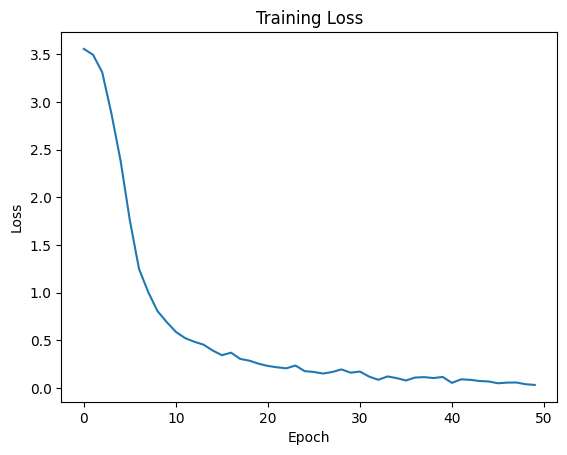

  0%|          | 0/207 [00:00<?, ?it/s]<ipython-input-27-f032b52d8ce3>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train = df_train.append(df_logit_train, ignore_index=True)
100%|██████████| 207/207 [00:05<00:00, 35.55it/s]
<ipython-input-27-f032b52d8ce3>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df_logit_test, ignore_index=True)
<ipython-input-27-f032b52d8ce3>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all = df_train.append(df_test,ignore_index=True)


MAI 5.csv saved


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1/50	Loss: 3.439026	Accuracy: 10.77%


  2%|▏         | 1/50 [00:18<14:45, 18.06s/it]

Test Loss: 3.305550, Test Accuracy: 11.19%
Epoch: 2/50	Loss: 2.948865	Accuracy: 30.14%


  4%|▍         | 2/50 [00:36<14:31, 18.16s/it]

Test Loss: 2.682900, Test Accuracy: 30.00%
Epoch: 3/50	Loss: 2.426386	Accuracy: 47.15%


  6%|▌         | 3/50 [00:53<14:00, 17.89s/it]

Test Loss: 2.099071, Test Accuracy: 47.31%
Epoch: 4/50	Loss: 1.756956	Accuracy: 60.01%


  8%|▊         | 4/50 [01:10<13:28, 17.59s/it]

Test Loss: 1.464689, Test Accuracy: 59.61%
Epoch: 5/50	Loss: 1.194181	Accuracy: 68.98%


 10%|█         | 5/50 [01:27<12:55, 17.22s/it]

Test Loss: 1.064281, Test Accuracy: 69.42%
Epoch: 6/50	Loss: 0.852562	Accuracy: 73.58%


 12%|█▏        | 6/50 [01:44<12:29, 17.03s/it]

Test Loss: 0.866871, Test Accuracy: 74.52%
Epoch: 7/50	Loss: 0.682709	Accuracy: 77.66%


 14%|█▍        | 7/50 [02:00<12:08, 16.93s/it]

Test Loss: 0.733446, Test Accuracy: 78.65%
Epoch: 8/50	Loss: 0.586326	Accuracy: 78.97%


 16%|█▌        | 8/50 [02:17<11:47, 16.84s/it]

Test Loss: 0.701187, Test Accuracy: 79.72%
Epoch: 9/50	Loss: 0.493306	Accuracy: 81.35%


 18%|█▊        | 9/50 [02:34<11:33, 16.90s/it]

Test Loss: 0.631799, Test Accuracy: 82.26%
Epoch: 10/50	Loss: 0.438580	Accuracy: 81.69%


 20%|██        | 10/50 [02:52<11:24, 17.12s/it]

Test Loss: 0.615024, Test Accuracy: 82.40%
Epoch: 11/50	Loss: 0.375769	Accuracy: 83.10%


 22%|██▏       | 11/50 [03:11<11:32, 17.75s/it]

Test Loss: 0.599413, Test Accuracy: 83.60%
Epoch: 12/50	Loss: 0.315587	Accuracy: 83.01%


 24%|██▍       | 12/50 [03:29<11:16, 17.80s/it]

Test Loss: 0.599413, Test Accuracy: 83.60%
Epoch: 13/50	Loss: 0.285180	Accuracy: 83.50%


 26%|██▌       | 13/50 [03:46<10:53, 17.65s/it]

Test Loss: 0.620428, Test Accuracy: 83.83%
Epoch: 14/50	Loss: 0.260276	Accuracy: 84.00%


 28%|██▊       | 14/50 [04:03<10:27, 17.42s/it]

Test Loss: 0.627366, Test Accuracy: 84.68%
Epoch: 15/50	Loss: 0.226850	Accuracy: 83.57%


 30%|███       | 15/50 [04:20<10:01, 17.19s/it]

Test Loss: 0.627366, Test Accuracy: 84.68%
Epoch: 16/50	Loss: 0.250000	Accuracy: 84.17%


 32%|███▏      | 16/50 [04:36<09:38, 17.03s/it]

Test Loss: 0.720325, Test Accuracy: 84.73%
Epoch: 17/50	Loss: 0.186902	Accuracy: 83.58%


 34%|███▍      | 17/50 [04:53<09:18, 16.93s/it]

Test Loss: 0.720325, Test Accuracy: 84.73%
Epoch: 18/50	Loss: 0.193230	Accuracy: 83.10%


 36%|███▌      | 18/50 [05:10<09:00, 16.89s/it]

Test Loss: 0.720325, Test Accuracy: 84.73%
Epoch: 19/50	Loss: 0.182246	Accuracy: 82.50%


 38%|███▊      | 19/50 [05:27<08:48, 17.06s/it]

Test Loss: 0.720325, Test Accuracy: 84.73%
Epoch: 20/50	Loss: 0.164141	Accuracy: 84.37%


 40%|████      | 20/50 [05:45<08:39, 17.31s/it]

Test Loss: 0.708268, Test Accuracy: 84.79%
Epoch: 21/50	Loss: 0.163723	Accuracy: 83.69%


 42%|████▏     | 21/50 [06:04<08:37, 17.85s/it]

Test Loss: 0.708268, Test Accuracy: 84.79%
Epoch: 22/50	Loss: 0.132613	Accuracy: 84.29%


 44%|████▍     | 22/50 [06:22<08:20, 17.88s/it]

Test Loss: 0.708268, Test Accuracy: 84.79%
Epoch: 23/50	Loss: 0.113602	Accuracy: 82.84%


 46%|████▌     | 23/50 [06:39<07:57, 17.70s/it]

Test Loss: 0.708268, Test Accuracy: 84.79%
Epoch: 24/50	Loss: 0.092935	Accuracy: 83.92%


 48%|████▊     | 24/50 [06:56<07:32, 17.42s/it]

Test Loss: 0.708268, Test Accuracy: 84.79%
Epoch: 25/50	Loss: 0.109931	Accuracy: 82.97%


 50%|█████     | 25/50 [07:13<07:10, 17.20s/it]

Test Loss: 0.708268, Test Accuracy: 84.79%
Epoch: 26/50	Loss: 0.123986	Accuracy: 83.38%


 52%|█████▏    | 26/50 [07:30<06:49, 17.08s/it]

Test Loss: 0.708268, Test Accuracy: 84.79%
Epoch: 27/50	Loss: 0.119561	Accuracy: 83.79%


 54%|█████▍    | 27/50 [07:46<06:29, 16.94s/it]

Test Loss: 0.708268, Test Accuracy: 84.79%
Epoch: 28/50	Loss: 0.102813	Accuracy: 83.47%


 56%|█████▌    | 28/50 [08:03<06:12, 16.94s/it]

Test Loss: 0.708268, Test Accuracy: 84.79%
Epoch: 29/50	Loss: 0.074936	Accuracy: 83.79%


 58%|█████▊    | 29/50 [08:21<05:58, 17.08s/it]

Test Loss: 0.708268, Test Accuracy: 84.79%
Epoch: 30/50	Loss: 0.072189	Accuracy: 83.90%


 60%|██████    | 30/50 [08:39<05:45, 17.29s/it]

Test Loss: 0.708268, Test Accuracy: 84.79%
Epoch: 31/50	Loss: 0.146905	Accuracy: 83.50%


 62%|██████▏   | 31/50 [08:57<05:33, 17.55s/it]

Test Loss: 0.708268, Test Accuracy: 84.79%
Epoch: 32/50	Loss: 0.090852	Accuracy: 84.08%


 64%|██████▍   | 32/50 [09:14<05:15, 17.52s/it]

Test Loss: 0.708268, Test Accuracy: 84.79%
Epoch: 33/50	Loss: 0.083160	Accuracy: 84.81%


 66%|██████▌   | 33/50 [09:31<04:53, 17.25s/it]

Test Loss: 0.971954, Test Accuracy: 85.31%
Epoch: 34/50	Loss: 0.069330	Accuracy: 84.32%


 68%|██████▊   | 34/50 [09:47<04:33, 17.08s/it]

Test Loss: 0.971954, Test Accuracy: 85.31%
Epoch: 35/50	Loss: 0.070212	Accuracy: 84.19%


 70%|███████   | 35/50 [10:04<04:14, 16.95s/it]

Test Loss: 0.971954, Test Accuracy: 85.31%
Epoch: 36/50	Loss: 0.102468	Accuracy: 84.11%


 72%|███████▏  | 36/50 [10:21<03:55, 16.86s/it]

Test Loss: 0.971954, Test Accuracy: 85.31%
Epoch: 37/50	Loss: 0.056680	Accuracy: 84.33%


 74%|███████▍  | 37/50 [10:38<03:39, 16.90s/it]

Test Loss: 0.971954, Test Accuracy: 85.31%
Epoch: 38/50	Loss: 0.046062	Accuracy: 83.51%


 76%|███████▌  | 38/50 [10:55<03:25, 17.13s/it]

Test Loss: 0.971954, Test Accuracy: 85.31%
Epoch: 39/50	Loss: 0.045915	Accuracy: 84.69%


 78%|███████▊  | 39/50 [11:13<03:10, 17.35s/it]

Test Loss: 0.971954, Test Accuracy: 85.31%
Epoch: 40/50	Loss: 0.049427	Accuracy: 84.87%


 80%|████████  | 40/50 [11:31<02:54, 17.47s/it]

Test Loss: 1.146965, Test Accuracy: 85.37%
Epoch: 41/50	Loss: 0.049325	Accuracy: 84.30%


 82%|████████▏ | 41/50 [11:48<02:36, 17.35s/it]

Test Loss: 1.146965, Test Accuracy: 85.37%
Epoch: 42/50	Loss: 0.062552	Accuracy: 84.50%


 84%|████████▍ | 42/50 [12:06<02:19, 17.46s/it]

Test Loss: 1.146965, Test Accuracy: 85.37%
Epoch: 43/50	Loss: 0.069160	Accuracy: 84.96%


 86%|████████▌ | 43/50 [12:23<02:00, 17.28s/it]

Test Loss: 1.078279, Test Accuracy: 85.18%
Epoch: 44/50	Loss: 0.061724	Accuracy: 84.14%


 88%|████████▊ | 44/50 [12:39<01:42, 17.08s/it]

Test Loss: 1.078279, Test Accuracy: 85.18%
Epoch: 45/50	Loss: 0.047930	Accuracy: 84.63%


 90%|█████████ | 45/50 [12:56<01:24, 16.94s/it]

Test Loss: 1.078279, Test Accuracy: 85.18%
Epoch: 46/50	Loss: 0.047853	Accuracy: 84.39%


 92%|█████████▏| 46/50 [13:13<01:07, 16.85s/it]

Test Loss: 1.078279, Test Accuracy: 85.18%
Epoch: 47/50	Loss: 0.046416	Accuracy: 84.79%


 94%|█████████▍| 47/50 [13:29<00:50, 16.77s/it]

Test Loss: 1.078279, Test Accuracy: 85.18%
Epoch: 48/50	Loss: 0.045565	Accuracy: 84.52%


 96%|█████████▌| 48/50 [13:46<00:33, 16.83s/it]

Test Loss: 1.078279, Test Accuracy: 85.18%
Epoch: 49/50	Loss: 0.032755	Accuracy: 85.20%


 98%|█████████▊| 49/50 [14:04<00:17, 17.07s/it]

Test Loss: 1.073903, Test Accuracy: 85.46%
Epoch: 50/50	Loss: 0.023780	Accuracy: 84.77%


100%|██████████| 50/50 [14:22<00:00, 17.24s/it]

Test Loss: 1.073903, Test Accuracy: 85.46%


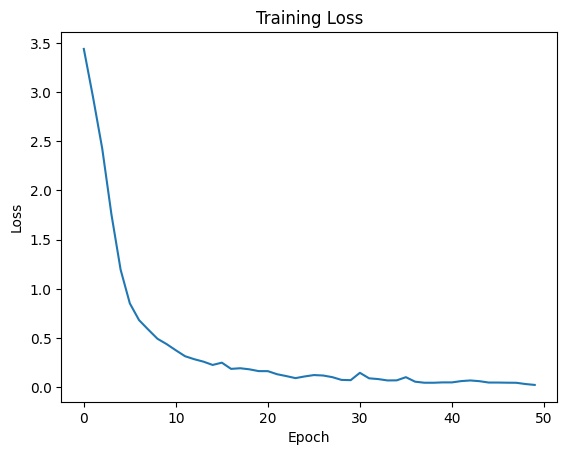

  0%|          | 0/207 [00:00<?, ?it/s]<ipython-input-27-f032b52d8ce3>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train = df_train.append(df_logit_train, ignore_index=True)
100%|██████████| 207/207 [00:04<00:00, 43.78it/s]
<ipython-input-27-f032b52d8ce3>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df_logit_test, ignore_index=True)
<ipython-input-27-f032b52d8ce3>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all = df_train.append(df_test,ignore_index=True)


MAI 6.csv saved


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1/50	Loss: 3.434422	Accuracy: 14.13%


  2%|▏         | 1/50 [00:18<14:46, 18.09s/it]

Test Loss: 3.184889, Test Accuracy: 13.88%
Epoch: 2/50	Loss: 2.979995	Accuracy: 28.34%


  4%|▍         | 2/50 [00:35<14:15, 17.83s/it]

Test Loss: 2.810892, Test Accuracy: 27.42%
Epoch: 3/50	Loss: 2.498026	Accuracy: 40.24%


  6%|▌         | 3/50 [00:52<13:35, 17.35s/it]

Test Loss: 2.348016, Test Accuracy: 39.45%
Epoch: 4/50	Loss: 1.851117	Accuracy: 60.23%


  8%|▊         | 4/50 [01:09<13:03, 17.03s/it]

Test Loss: 1.524650, Test Accuracy: 59.23%
Epoch: 5/50	Loss: 1.219799	Accuracy: 70.65%


 10%|█         | 5/50 [01:25<12:38, 16.85s/it]

Test Loss: 1.037784, Test Accuracy: 70.07%
Epoch: 6/50	Loss: 0.869210	Accuracy: 75.88%


 12%|█▏        | 6/50 [01:42<12:17, 16.76s/it]

Test Loss: 0.857031, Test Accuracy: 75.45%
Epoch: 7/50	Loss: 0.701138	Accuracy: 77.48%


 14%|█▍        | 7/50 [01:58<11:58, 16.71s/it]

Test Loss: 0.788655, Test Accuracy: 76.79%
Epoch: 8/50	Loss: 0.587362	Accuracy: 80.25%


 16%|█▌        | 8/50 [02:15<11:43, 16.76s/it]

Test Loss: 0.716790, Test Accuracy: 79.59%
Epoch: 9/50	Loss: 0.500762	Accuracy: 80.07%


 18%|█▊        | 9/50 [02:32<11:33, 16.91s/it]

Test Loss: 0.716790, Test Accuracy: 79.59%
Epoch: 10/50	Loss: 0.428968	Accuracy: 81.60%


 20%|██        | 10/50 [02:50<11:26, 17.16s/it]

Test Loss: 0.678133, Test Accuracy: 80.75%
Epoch: 11/50	Loss: 0.402394	Accuracy: 80.21%


 22%|██▏       | 11/50 [03:08<11:21, 17.48s/it]

Test Loss: 0.678133, Test Accuracy: 80.75%
Epoch: 12/50	Loss: 0.358994	Accuracy: 82.28%


 24%|██▍       | 12/50 [03:27<11:17, 17.82s/it]

Test Loss: 0.669400, Test Accuracy: 81.56%
Epoch: 13/50	Loss: 0.322128	Accuracy: 82.82%


 26%|██▌       | 13/50 [03:44<10:55, 17.72s/it]

Test Loss: 0.679518, Test Accuracy: 82.13%
Epoch: 14/50	Loss: 0.257442	Accuracy: 83.63%


 28%|██▊       | 14/50 [04:02<10:32, 17.56s/it]

Test Loss: 0.703181, Test Accuracy: 82.97%
Epoch: 15/50	Loss: 0.279789	Accuracy: 83.28%


 30%|███       | 15/50 [04:18<10:07, 17.36s/it]

Test Loss: 0.703181, Test Accuracy: 82.97%
Epoch: 16/50	Loss: 0.232099	Accuracy: 82.80%


 32%|███▏      | 16/50 [04:35<09:43, 17.16s/it]

Test Loss: 0.703181, Test Accuracy: 82.97%
Epoch: 17/50	Loss: 0.215661	Accuracy: 83.94%


 34%|███▍      | 17/50 [04:52<09:21, 17.01s/it]

Test Loss: 0.763837, Test Accuracy: 83.31%
Epoch: 18/50	Loss: 0.183922	Accuracy: 84.27%


 36%|███▌      | 18/50 [05:09<09:01, 16.92s/it]

Test Loss: 0.779426, Test Accuracy: 83.84%
Epoch: 19/50	Loss: 0.164268	Accuracy: 83.89%


 38%|███▊      | 19/50 [05:25<08:42, 16.86s/it]

Test Loss: 0.779426, Test Accuracy: 83.84%
Epoch: 20/50	Loss: 0.212086	Accuracy: 84.09%


 40%|████      | 20/50 [05:42<08:24, 16.81s/it]

Test Loss: 0.779426, Test Accuracy: 83.84%
Epoch: 21/50	Loss: 0.135192	Accuracy: 84.30%


 42%|████▏     | 21/50 [05:59<08:08, 16.85s/it]

Test Loss: 0.807775, Test Accuracy: 83.47%
Epoch: 22/50	Loss: 0.123692	Accuracy: 83.21%


 44%|████▍     | 22/50 [06:16<07:56, 17.03s/it]

Test Loss: 0.807775, Test Accuracy: 83.47%
Epoch: 23/50	Loss: 0.147747	Accuracy: 83.70%


 46%|████▌     | 23/50 [06:33<07:40, 17.05s/it]

Test Loss: 0.807775, Test Accuracy: 83.47%
Epoch: 24/50	Loss: 0.121914	Accuracy: 84.06%


 48%|████▊     | 24/50 [06:50<07:20, 16.94s/it]

Test Loss: 0.807775, Test Accuracy: 83.47%
Epoch: 25/50	Loss: 0.123975	Accuracy: 84.03%


 50%|█████     | 25/50 [07:07<07:03, 16.95s/it]

Test Loss: 0.807775, Test Accuracy: 83.47%
Epoch: 26/50	Loss: 0.104342	Accuracy: 83.54%


 52%|█████▏    | 26/50 [07:24<06:48, 17.04s/it]

Test Loss: 0.807775, Test Accuracy: 83.47%
Epoch: 27/50	Loss: 0.103520	Accuracy: 84.09%


 54%|█████▍    | 27/50 [07:42<06:36, 17.23s/it]

Test Loss: 0.807775, Test Accuracy: 83.47%
Epoch: 28/50	Loss: 0.084765	Accuracy: 84.62%


 56%|█████▌    | 28/50 [08:00<06:24, 17.46s/it]

Test Loss: 0.934320, Test Accuracy: 83.79%
Epoch: 29/50	Loss: 0.097603	Accuracy: 83.86%


 58%|█████▊    | 29/50 [08:18<06:10, 17.63s/it]

Test Loss: 0.934320, Test Accuracy: 83.79%
Epoch: 30/50	Loss: 0.073916	Accuracy: 84.31%


 60%|██████    | 30/50 [08:35<05:51, 17.56s/it]

Test Loss: 0.934320, Test Accuracy: 83.79%
Epoch: 31/50	Loss: 0.093599	Accuracy: 84.35%


 62%|██████▏   | 31/50 [08:53<05:30, 17.41s/it]

Test Loss: 0.934320, Test Accuracy: 83.79%
Epoch: 32/50	Loss: 0.081576	Accuracy: 84.36%


 64%|██████▍   | 32/50 [09:09<05:09, 17.18s/it]

Test Loss: 0.934320, Test Accuracy: 83.79%
Epoch: 33/50	Loss: 0.059941	Accuracy: 84.70%


 66%|██████▌   | 33/50 [09:27<04:56, 17.44s/it]

Test Loss: 0.988276, Test Accuracy: 84.25%
Epoch: 34/50	Loss: 0.069656	Accuracy: 84.80%


 68%|██████▊   | 34/50 [09:44<04:37, 17.33s/it]

Test Loss: 0.924218, Test Accuracy: 84.28%
Epoch: 35/50	Loss: 0.068394	Accuracy: 84.34%


 70%|███████   | 35/50 [10:01<04:17, 17.17s/it]

Test Loss: 0.924218, Test Accuracy: 84.28%
Epoch: 36/50	Loss: 0.068896	Accuracy: 85.05%


 72%|███████▏  | 36/50 [10:18<03:58, 17.02s/it]

Test Loss: 1.040919, Test Accuracy: 84.29%
Epoch: 37/50	Loss: 0.058737	Accuracy: 84.52%


 74%|███████▍  | 37/50 [10:34<03:39, 16.92s/it]

Test Loss: 1.040919, Test Accuracy: 84.29%
Epoch: 38/50	Loss: 0.098375	Accuracy: 84.33%


 76%|███████▌  | 38/50 [10:51<03:22, 16.86s/it]

Test Loss: 1.040919, Test Accuracy: 84.29%
Epoch: 39/50	Loss: 0.052559	Accuracy: 85.43%


 78%|███████▊  | 39/50 [11:08<03:05, 16.82s/it]

Test Loss: 1.100062, Test Accuracy: 84.65%
Epoch: 40/50	Loss: 0.058950	Accuracy: 84.82%


 80%|████████  | 40/50 [11:25<02:48, 16.87s/it]

Test Loss: 1.100062, Test Accuracy: 84.65%
Epoch: 41/50	Loss: 0.047201	Accuracy: 85.09%


 82%|████████▏ | 41/50 [11:42<02:33, 17.01s/it]

Test Loss: 1.100062, Test Accuracy: 84.65%
Epoch: 42/50	Loss: 0.062083	Accuracy: 84.65%


 84%|████████▍ | 42/50 [12:00<02:18, 17.26s/it]

Test Loss: 1.100062, Test Accuracy: 84.65%
Epoch: 43/50	Loss: 0.048103	Accuracy: 84.99%


 86%|████████▌ | 43/50 [12:19<02:03, 17.63s/it]

Test Loss: 1.100062, Test Accuracy: 84.65%
Epoch: 44/50	Loss: 0.057679	Accuracy: 84.59%


 88%|████████▊ | 44/50 [12:37<01:47, 17.92s/it]

Test Loss: 1.100062, Test Accuracy: 84.65%
Epoch: 45/50	Loss: 0.050328	Accuracy: 84.72%


 90%|█████████ | 45/50 [12:55<01:29, 17.81s/it]

Test Loss: 1.100062, Test Accuracy: 84.65%
Epoch: 46/50	Loss: 0.057782	Accuracy: 84.84%


 92%|█████████▏| 46/50 [13:12<01:10, 17.67s/it]

Test Loss: 1.100062, Test Accuracy: 84.65%
Epoch: 47/50	Loss: 0.069383	Accuracy: 84.81%


 94%|█████████▍| 47/50 [13:29<00:52, 17.40s/it]

Test Loss: 1.100062, Test Accuracy: 84.65%
Epoch: 48/50	Loss: 0.058701	Accuracy: 84.30%


 96%|█████████▌| 48/50 [13:46<00:34, 17.21s/it]

Test Loss: 1.100062, Test Accuracy: 84.65%
Epoch: 49/50	Loss: 0.036950	Accuracy: 85.41%


 98%|█████████▊| 49/50 [14:02<00:17, 17.05s/it]

Test Loss: 1.100062, Test Accuracy: 84.65%
Epoch: 50/50	Loss: 0.027535	Accuracy: 85.55%


100%|██████████| 50/50 [14:19<00:00, 17.19s/it]

Test Loss: 1.105702, Test Accuracy: 84.98%


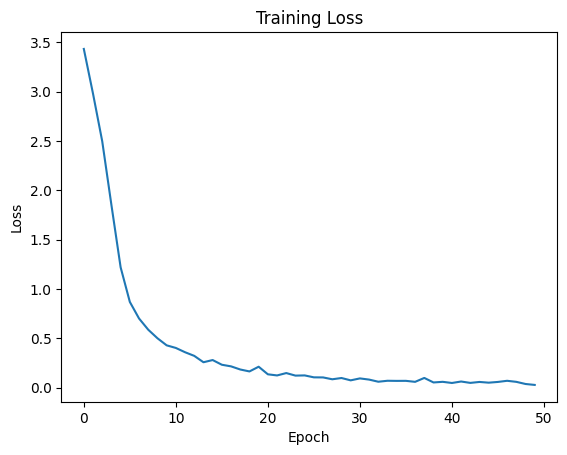

  0%|          | 0/207 [00:00<?, ?it/s]<ipython-input-27-f032b52d8ce3>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train = df_train.append(df_logit_train, ignore_index=True)
100%|██████████| 207/207 [00:05<00:00, 37.40it/s]
<ipython-input-27-f032b52d8ce3>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df_logit_test, ignore_index=True)
<ipython-input-27-f032b52d8ce3>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all = df_train.append(df_test,ignore_index=True)


MAI 7.csv saved


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1/50	Loss: 3.480227	Accuracy: 15.03%


  2%|▏         | 1/50 [00:16<13:40, 16.75s/it]

Test Loss: 3.220257, Test Accuracy: 14.54%
Epoch: 2/50	Loss: 3.010367	Accuracy: 30.50%


  4%|▍         | 2/50 [00:33<13:30, 16.89s/it]

Test Loss: 2.716696, Test Accuracy: 30.57%
Epoch: 3/50	Loss: 2.481987	Accuracy: 45.03%


  6%|▌         | 3/50 [00:52<13:46, 17.58s/it]

Test Loss: 2.196143, Test Accuracy: 45.44%
Epoch: 4/50	Loss: 1.869034	Accuracy: 54.19%


  8%|▊         | 4/50 [01:09<13:16, 17.31s/it]

Test Loss: 1.598223, Test Accuracy: 54.57%
Epoch: 5/50	Loss: 1.150396	Accuracy: 69.37%


 10%|█         | 5/50 [01:26<12:56, 17.25s/it]

Test Loss: 1.053858, Test Accuracy: 69.31%
Epoch: 6/50	Loss: 0.823503	Accuracy: 76.57%


 12%|█▏        | 6/50 [01:43<12:40, 17.28s/it]

Test Loss: 0.788134, Test Accuracy: 76.52%
Epoch: 7/50	Loss: 0.679135	Accuracy: 77.33%


 14%|█▍        | 7/50 [02:01<12:29, 17.42s/it]

Test Loss: 0.754990, Test Accuracy: 77.98%
Epoch: 8/50	Loss: 0.588461	Accuracy: 77.44%


 16%|█▌        | 8/50 [02:19<12:20, 17.64s/it]

Test Loss: 0.759799, Test Accuracy: 77.67%
Epoch: 9/50	Loss: 0.476322	Accuracy: 80.19%


 18%|█▊        | 9/50 [02:37<12:12, 17.86s/it]

Test Loss: 0.676669, Test Accuracy: 80.36%
Epoch: 10/50	Loss: 0.423052	Accuracy: 81.66%


 20%|██        | 10/50 [02:55<11:57, 17.94s/it]

Test Loss: 0.628766, Test Accuracy: 81.60%
Epoch: 11/50	Loss: 0.377056	Accuracy: 81.84%


 22%|██▏       | 11/50 [03:13<11:36, 17.86s/it]

Test Loss: 0.649263, Test Accuracy: 81.68%
Epoch: 12/50	Loss: 0.365352	Accuracy: 82.25%


 24%|██▍       | 12/50 [03:30<11:13, 17.72s/it]

Test Loss: 0.643469, Test Accuracy: 82.18%
Epoch: 13/50	Loss: 0.300963	Accuracy: 82.77%


 26%|██▌       | 13/50 [03:49<11:01, 17.87s/it]

Test Loss: 0.666007, Test Accuracy: 82.76%
Epoch: 14/50	Loss: 0.270687	Accuracy: 82.29%


 28%|██▊       | 14/50 [04:06<10:35, 17.66s/it]

Test Loss: 0.666007, Test Accuracy: 82.76%
Epoch: 15/50	Loss: 0.217780	Accuracy: 83.15%


 30%|███       | 15/50 [04:23<10:09, 17.43s/it]

Test Loss: 0.723354, Test Accuracy: 82.97%
Epoch: 16/50	Loss: 0.225769	Accuracy: 82.51%


 32%|███▏      | 16/50 [04:39<09:46, 17.24s/it]

Test Loss: 0.723354, Test Accuracy: 82.97%
Epoch: 17/50	Loss: 0.217925	Accuracy: 82.07%


 34%|███▍      | 17/50 [04:56<09:25, 17.13s/it]

Test Loss: 0.723354, Test Accuracy: 82.97%
Epoch: 18/50	Loss: 0.180182	Accuracy: 83.35%


 36%|███▌      | 18/50 [05:13<09:05, 17.05s/it]

Test Loss: 0.768177, Test Accuracy: 83.35%
Epoch: 19/50	Loss: 0.164081	Accuracy: 83.34%


 38%|███▊      | 19/50 [05:30<08:47, 17.00s/it]

Test Loss: 0.768177, Test Accuracy: 83.35%
Epoch: 20/50	Loss: 0.253659	Accuracy: 82.65%


 40%|████      | 20/50 [05:47<08:29, 16.97s/it]

Test Loss: 0.768177, Test Accuracy: 83.35%
Epoch: 21/50	Loss: 0.148435	Accuracy: 83.92%


 42%|████▏     | 21/50 [06:04<08:13, 17.03s/it]

Test Loss: 0.777199, Test Accuracy: 83.82%
Epoch: 22/50	Loss: 0.121915	Accuracy: 84.11%


 44%|████▍     | 22/50 [06:21<07:59, 17.11s/it]

Test Loss: 0.860652, Test Accuracy: 84.12%
Epoch: 23/50	Loss: 0.124944	Accuracy: 83.68%


 46%|████▌     | 23/50 [06:39<07:44, 17.19s/it]

Test Loss: 0.860652, Test Accuracy: 84.12%
Epoch: 24/50	Loss: 0.104727	Accuracy: 84.54%


 48%|████▊     | 24/50 [06:59<07:46, 17.96s/it]

Test Loss: 0.778613, Test Accuracy: 84.39%
Epoch: 25/50	Loss: 0.108783	Accuracy: 83.47%


 50%|█████     | 25/50 [07:18<07:42, 18.48s/it]

Test Loss: 0.778613, Test Accuracy: 84.39%
Epoch: 26/50	Loss: 0.106195	Accuracy: 83.41%


 52%|█████▏    | 26/50 [07:39<07:38, 19.09s/it]

Test Loss: 0.778613, Test Accuracy: 84.39%
Epoch: 27/50	Loss: 0.119306	Accuracy: 83.59%


 54%|█████▍    | 27/50 [07:59<07:26, 19.40s/it]

Test Loss: 0.778613, Test Accuracy: 84.39%
Epoch: 28/50	Loss: 0.093272	Accuracy: 84.22%


 56%|█████▌    | 28/50 [08:16<06:49, 18.62s/it]

Test Loss: 0.778613, Test Accuracy: 84.39%
Epoch: 29/50	Loss: 0.079621	Accuracy: 84.30%


 58%|█████▊    | 29/50 [08:33<06:19, 18.07s/it]

Test Loss: 0.778613, Test Accuracy: 84.39%
Epoch: 30/50	Loss: 0.068348	Accuracy: 84.37%


 60%|██████    | 30/50 [08:49<05:53, 17.68s/it]

Test Loss: 0.778613, Test Accuracy: 84.39%
Epoch: 31/50	Loss: 0.140697	Accuracy: 84.18%


 62%|██████▏   | 31/50 [09:07<05:38, 17.82s/it]

Test Loss: 0.778613, Test Accuracy: 84.39%
Epoch: 32/50	Loss: 0.115549	Accuracy: 84.32%


 64%|██████▍   | 32/50 [09:27<05:31, 18.39s/it]

Test Loss: 0.778613, Test Accuracy: 84.39%
Epoch: 33/50	Loss: 0.074616	Accuracy: 84.11%


 66%|██████▌   | 33/50 [09:46<05:13, 18.42s/it]

Test Loss: 0.778613, Test Accuracy: 84.39%
Epoch: 34/50	Loss: 0.094490	Accuracy: 84.13%


 68%|██████▊   | 34/50 [10:05<04:59, 18.73s/it]

Test Loss: 0.778613, Test Accuracy: 84.39%
Epoch: 35/50	Loss: 0.061953	Accuracy: 84.68%


 70%|███████   | 35/50 [10:23<04:39, 18.63s/it]

Test Loss: 0.986653, Test Accuracy: 84.94%
Epoch: 36/50	Loss: 0.079462	Accuracy: 83.14%


 72%|███████▏  | 36/50 [10:42<04:18, 18.49s/it]

Test Loss: 0.986653, Test Accuracy: 84.94%
Epoch: 37/50	Loss: 0.054345	Accuracy: 84.59%


 74%|███████▍  | 37/50 [11:00<03:59, 18.44s/it]

Test Loss: 0.986653, Test Accuracy: 84.94%
Epoch: 38/50	Loss: 0.053161	Accuracy: 84.41%


 76%|███████▌  | 38/50 [11:17<03:37, 18.14s/it]

Test Loss: 0.986653, Test Accuracy: 84.94%
Epoch: 39/50	Loss: 0.047353	Accuracy: 83.51%


 78%|███████▊  | 39/50 [11:37<03:25, 18.68s/it]

Test Loss: 0.986653, Test Accuracy: 84.94%
Epoch: 40/50	Loss: 0.050959	Accuracy: 85.05%


 80%|████████  | 40/50 [11:55<03:02, 18.28s/it]

Test Loss: 1.078210, Test Accuracy: 84.91%
Epoch: 41/50	Loss: 0.048063	Accuracy: 83.95%


 82%|████████▏ | 41/50 [12:13<02:45, 18.44s/it]

Test Loss: 1.078210, Test Accuracy: 84.91%
Epoch: 42/50	Loss: 0.045672	Accuracy: 84.19%


 84%|████████▍ | 42/50 [12:31<02:25, 18.20s/it]

Test Loss: 1.078210, Test Accuracy: 84.91%
Epoch: 43/50	Loss: 0.027045	Accuracy: 83.51%


 86%|████████▌ | 43/50 [12:49<02:06, 18.08s/it]

Test Loss: 1.078210, Test Accuracy: 84.91%
Epoch: 44/50	Loss: 0.068215	Accuracy: 82.42%


 88%|████████▊ | 44/50 [13:09<01:51, 18.64s/it]

Test Loss: 1.078210, Test Accuracy: 84.91%
Epoch: 45/50	Loss: 0.065544	Accuracy: 83.81%


 90%|█████████ | 45/50 [13:27<01:33, 18.63s/it]

Test Loss: 1.078210, Test Accuracy: 84.91%
Epoch: 46/50	Loss: 0.065889	Accuracy: 84.32%


 92%|█████████▏| 46/50 [13:46<01:14, 18.58s/it]

Test Loss: 1.078210, Test Accuracy: 84.91%
Epoch: 47/50	Loss: 0.038336	Accuracy: 84.75%


 94%|█████████▍| 47/50 [14:04<00:55, 18.44s/it]

Test Loss: 1.078210, Test Accuracy: 84.91%
Epoch: 48/50	Loss: 0.057747	Accuracy: 83.84%


 96%|█████████▌| 48/50 [14:22<00:36, 18.18s/it]

Test Loss: 1.078210, Test Accuracy: 84.91%
Epoch: 49/50	Loss: 0.046283	Accuracy: 84.44%


 98%|█████████▊| 49/50 [14:39<00:17, 17.95s/it]

Test Loss: 1.078210, Test Accuracy: 84.91%
Epoch: 50/50	Loss: 0.027203	Accuracy: 84.19%


100%|██████████| 50/50 [14:56<00:00, 17.93s/it]

Test Loss: 1.078210, Test Accuracy: 84.91%


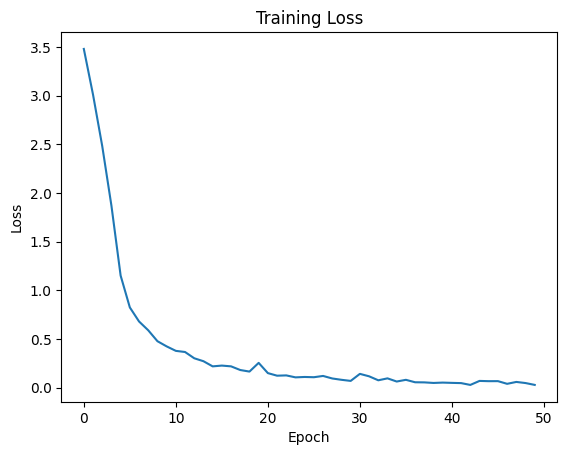

  0%|          | 0/207 [00:00<?, ?it/s]<ipython-input-27-f032b52d8ce3>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train = df_train.append(df_logit_train, ignore_index=True)
100%|██████████| 207/207 [00:05<00:00, 36.30it/s]
<ipython-input-27-f032b52d8ce3>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df_logit_test, ignore_index=True)
<ipython-input-27-f032b52d8ce3>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all = df_train.append(df_test,ignore_index=True)


MAI 8.csv saved


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1/50	Loss: 3.551603	Accuracy: 7.53%


  2%|▏         | 1/50 [00:16<13:42, 16.79s/it]

Test Loss: 3.457044, Test Accuracy: 7.49%
Epoch: 2/50	Loss: 3.273938	Accuracy: 15.39%


  4%|▍         | 2/50 [00:33<13:29, 16.87s/it]

Test Loss: 3.109254, Test Accuracy: 15.41%
Epoch: 3/50	Loss: 2.875756	Accuracy: 28.25%


  6%|▌         | 3/50 [00:50<13:10, 16.83s/it]

Test Loss: 2.731688, Test Accuracy: 27.69%
Epoch: 4/50	Loss: 2.401545	Accuracy: 43.33%


  8%|▊         | 4/50 [01:08<13:13, 17.26s/it]

Test Loss: 2.174632, Test Accuracy: 42.99%
Epoch: 5/50	Loss: 1.793063	Accuracy: 60.31%


 10%|█         | 5/50 [01:25<13:00, 17.34s/it]

Test Loss: 1.454960, Test Accuracy: 60.64%
Epoch: 6/50	Loss: 1.230593	Accuracy: 66.56%


 12%|█▏        | 6/50 [01:43<12:42, 17.33s/it]

Test Loss: 1.119076, Test Accuracy: 67.12%
Epoch: 7/50	Loss: 0.914211	Accuracy: 72.91%


 14%|█▍        | 7/50 [02:00<12:22, 17.27s/it]

Test Loss: 0.898884, Test Accuracy: 73.09%
Epoch: 8/50	Loss: 0.750406	Accuracy: 75.02%


 16%|█▌        | 8/50 [02:17<12:01, 17.17s/it]

Test Loss: 0.832780, Test Accuracy: 76.04%
Epoch: 9/50	Loss: 0.630085	Accuracy: 78.58%


 18%|█▊        | 9/50 [02:34<11:41, 17.12s/it]

Test Loss: 0.720522, Test Accuracy: 79.12%
Epoch: 10/50	Loss: 0.572551	Accuracy: 79.71%


 20%|██        | 10/50 [02:51<11:23, 17.08s/it]

Test Loss: 0.679181, Test Accuracy: 80.37%
Epoch: 11/50	Loss: 0.506949	Accuracy: 81.79%


 22%|██▏       | 11/50 [03:08<11:05, 17.05s/it]

Test Loss: 0.658950, Test Accuracy: 81.81%
Epoch: 12/50	Loss: 0.442317	Accuracy: 81.57%


 24%|██▍       | 12/50 [03:25<10:47, 17.04s/it]

Test Loss: 0.658950, Test Accuracy: 81.81%
Epoch: 13/50	Loss: 0.381560	Accuracy: 81.52%


 26%|██▌       | 13/50 [03:42<10:28, 16.99s/it]

Test Loss: 0.658950, Test Accuracy: 81.81%
Epoch: 14/50	Loss: 0.340365	Accuracy: 81.10%


 28%|██▊       | 14/50 [03:58<10:09, 16.92s/it]

Test Loss: 0.658950, Test Accuracy: 81.81%
Epoch: 15/50	Loss: 0.293823	Accuracy: 81.75%


 30%|███       | 15/50 [04:17<10:07, 17.35s/it]

Test Loss: 0.658950, Test Accuracy: 81.81%
Epoch: 16/50	Loss: 0.304153	Accuracy: 83.63%


 32%|███▏      | 16/50 [04:34<09:51, 17.41s/it]

Test Loss: 0.649922, Test Accuracy: 84.04%
Epoch: 17/50	Loss: 0.309423	Accuracy: 82.50%


 34%|███▍      | 17/50 [04:52<09:35, 17.44s/it]

Test Loss: 0.649922, Test Accuracy: 84.04%
Epoch: 18/50	Loss: 0.233597	Accuracy: 83.35%


 36%|███▌      | 18/50 [05:09<09:16, 17.39s/it]

Test Loss: 0.649922, Test Accuracy: 84.04%
Epoch: 19/50	Loss: 0.253810	Accuracy: 83.60%


 38%|███▊      | 19/50 [05:26<08:56, 17.31s/it]

Test Loss: 0.649922, Test Accuracy: 84.04%
Epoch: 20/50	Loss: 0.228970	Accuracy: 81.93%


 40%|████      | 20/50 [05:43<08:34, 17.16s/it]

Test Loss: 0.649922, Test Accuracy: 84.04%
Epoch: 21/50	Loss: 0.188123	Accuracy: 84.08%


 42%|████▏     | 21/50 [06:00<08:14, 17.05s/it]

Test Loss: 0.756777, Test Accuracy: 84.29%
Epoch: 22/50	Loss: 0.163716	Accuracy: 82.69%


 44%|████▍     | 22/50 [06:17<07:55, 16.99s/it]

Test Loss: 0.756777, Test Accuracy: 84.29%
Epoch: 23/50	Loss: 0.163831	Accuracy: 83.10%


 46%|████▌     | 23/50 [06:34<07:37, 16.94s/it]

Test Loss: 0.756777, Test Accuracy: 84.29%
Epoch: 24/50	Loss: 0.151495	Accuracy: 84.40%


 48%|████▊     | 24/50 [06:50<07:19, 16.90s/it]

Test Loss: 0.763764, Test Accuracy: 84.64%
Epoch: 25/50	Loss: 0.161147	Accuracy: 82.90%


 50%|█████     | 25/50 [07:07<07:01, 16.88s/it]

Test Loss: 0.763764, Test Accuracy: 84.64%
Epoch: 26/50	Loss: 0.155615	Accuracy: 83.09%


 52%|█████▏    | 26/50 [07:25<06:52, 17.20s/it]

Test Loss: 0.763764, Test Accuracy: 84.64%
Epoch: 27/50	Loss: 0.139581	Accuracy: 83.99%


 54%|█████▍    | 27/50 [07:42<06:36, 17.23s/it]

Test Loss: 0.763764, Test Accuracy: 84.64%
Epoch: 28/50	Loss: 0.096609	Accuracy: 83.58%


 56%|█████▌    | 28/50 [07:59<06:17, 17.16s/it]

Test Loss: 0.763764, Test Accuracy: 84.64%
Epoch: 29/50	Loss: 0.115689	Accuracy: 83.27%


 58%|█████▊    | 29/50 [08:16<05:57, 17.04s/it]

Test Loss: 0.763764, Test Accuracy: 84.64%
Epoch: 30/50	Loss: 0.134467	Accuracy: 83.44%


 60%|██████    | 30/50 [08:33<05:39, 16.96s/it]

Test Loss: 0.763764, Test Accuracy: 84.64%
Epoch: 31/50	Loss: 0.092056	Accuracy: 84.17%


 62%|██████▏   | 31/50 [08:50<05:21, 16.91s/it]

Test Loss: 0.763764, Test Accuracy: 84.64%
Epoch: 32/50	Loss: 0.077379	Accuracy: 83.73%


 64%|██████▍   | 32/50 [09:06<05:03, 16.86s/it]

Test Loss: 0.763764, Test Accuracy: 84.64%
Epoch: 33/50	Loss: 0.081645	Accuracy: 84.75%


 66%|██████▌   | 33/50 [09:23<04:46, 16.83s/it]

Test Loss: 1.033914, Test Accuracy: 84.78%
Epoch: 34/50	Loss: 0.077483	Accuracy: 83.45%


 68%|██████▊   | 34/50 [09:40<04:29, 16.82s/it]

Test Loss: 1.033914, Test Accuracy: 84.78%
Epoch: 35/50	Loss: 0.091210	Accuracy: 83.52%


 70%|███████   | 35/50 [09:57<04:12, 16.82s/it]

Test Loss: 1.033914, Test Accuracy: 84.78%
Epoch: 36/50	Loss: 0.070056	Accuracy: 82.59%


 72%|███████▏  | 36/50 [10:14<03:55, 16.83s/it]

Test Loss: 1.033914, Test Accuracy: 84.78%
Epoch: 37/50	Loss: 0.080186	Accuracy: 83.53%


 74%|███████▍  | 37/50 [10:32<03:42, 17.15s/it]

Test Loss: 1.033914, Test Accuracy: 84.78%
Epoch: 38/50	Loss: 0.068537	Accuracy: 84.63%


 76%|███████▌  | 38/50 [10:48<03:24, 17.05s/it]

Test Loss: 1.033914, Test Accuracy: 84.78%
Epoch: 39/50	Loss: 0.074585	Accuracy: 83.55%


 78%|███████▊  | 39/50 [11:05<03:06, 16.94s/it]

Test Loss: 1.033914, Test Accuracy: 84.78%
Epoch: 40/50	Loss: 0.060287	Accuracy: 84.57%


 80%|████████  | 40/50 [11:22<02:48, 16.89s/it]

Test Loss: 1.033914, Test Accuracy: 84.78%
Epoch: 41/50	Loss: 0.066397	Accuracy: 83.44%


 82%|████████▏ | 41/50 [11:39<02:31, 16.83s/it]

Test Loss: 1.033914, Test Accuracy: 84.78%
Epoch: 42/50	Loss: 0.062517	Accuracy: 84.10%


 84%|████████▍ | 42/50 [11:55<02:14, 16.80s/it]

Test Loss: 1.033914, Test Accuracy: 84.78%
Epoch: 43/50	Loss: 0.099125	Accuracy: 83.83%


 86%|████████▌ | 43/50 [12:12<01:57, 16.78s/it]

Test Loss: 1.033914, Test Accuracy: 84.78%
Epoch: 44/50	Loss: 0.070930	Accuracy: 83.95%


 88%|████████▊ | 44/50 [12:29<01:40, 16.77s/it]

Test Loss: 1.033914, Test Accuracy: 84.78%
Epoch: 45/50	Loss: 0.065825	Accuracy: 83.91%


 90%|█████████ | 45/50 [12:46<01:23, 16.76s/it]

Test Loss: 1.033914, Test Accuracy: 84.78%
Epoch: 46/50	Loss: 0.052421	Accuracy: 84.60%


 92%|█████████▏| 46/50 [13:02<01:06, 16.74s/it]

Test Loss: 1.033914, Test Accuracy: 84.78%
Epoch: 47/50	Loss: 0.040341	Accuracy: 84.60%


 94%|█████████▍| 47/50 [13:19<00:50, 16.75s/it]

Test Loss: 1.033914, Test Accuracy: 84.78%
Epoch: 48/50	Loss: 0.045977	Accuracy: 84.16%


 96%|█████████▌| 48/50 [13:37<00:34, 17.23s/it]

Test Loss: 1.033914, Test Accuracy: 84.78%
Epoch: 49/50	Loss: 0.049430	Accuracy: 84.23%


 98%|█████████▊| 49/50 [13:55<00:17, 17.21s/it]

Test Loss: 1.033914, Test Accuracy: 84.78%
Epoch: 50/50	Loss: 0.055186	Accuracy: 84.89%


100%|██████████| 50/50 [14:12<00:00, 17.05s/it]

Test Loss: 1.021205, Test Accuracy: 85.05%


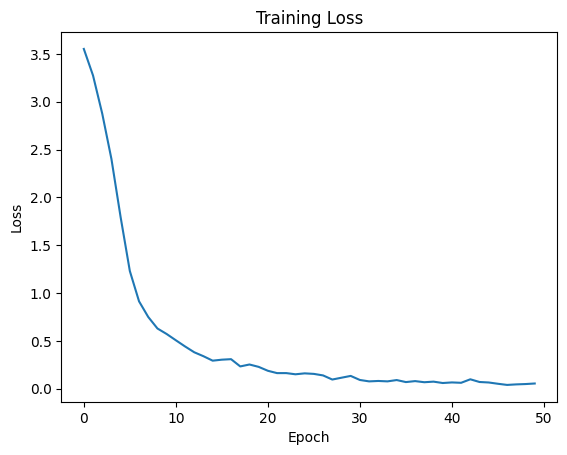

  0%|          | 0/207 [00:00<?, ?it/s]<ipython-input-27-f032b52d8ce3>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train = df_train.append(df_logit_train, ignore_index=True)
100%|██████████| 207/207 [00:06<00:00, 34.26it/s]
<ipython-input-27-f032b52d8ce3>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df_logit_test, ignore_index=True)
<ipython-input-27-f032b52d8ce3>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all = df_train.append(df_test,ignore_index=True)


MAI 9.csv saved


In [ ]:
membership_inference_attack(all_mel)

# Plotting Membership Inference

In [ ]:
df_mia = pd.DataFrame()
for i in range (10):
  path = (f"MAI {i}.csv")
  df = pd.read_csv(path)
  df_mia = df_mia.append(df, ignore_index=True)


<ipython-input-2-7c7f21627f25>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mia = df_mia.append(df, ignore_index=True)
<ipython-input-2-7c7f21627f25>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mia = df_mia.append(df, ignore_index=True)
<ipython-input-2-7c7f21627f25>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mia = df_mia.append(df, ignore_index=True)
<ipython-input-2-7c7f21627f25>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mia = df_mia.append(df, ignore_index=True)
<ipython-input-2-7c7f21627f25>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. 

In [ ]:
df_mia

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,label
0,1.970460e-18,1.658503e-17,1.712880e-17,2.675474e-16,3.908157e-18,5.991500e-12,4.538617e-12,6.847980e-08,2.930603e-08,6.656424e-18,...,2.467679e-15,1.985548e-20,2.602776e-20,1.133089e-21,1.633511e-12,1.997537e-20,3.063995e-09,5.315932e-21,2.497018e-20,0
1,2.720270e-25,2.005303e-19,6.699119e-18,2.962567e-22,1.125561e-17,7.735267e-18,1.540497e-25,5.143722e-27,2.096732e-21,1.374576e-23,...,6.127717e-19,4.581320e-24,9.090624e-25,4.188155e-19,8.826179e-24,5.531325e-28,4.897549e-20,1.943647e-22,4.795508e-24,0
2,1.299161e-15,3.309004e-15,2.647442e-12,7.314780e-14,1.391761e-15,2.684169e-11,4.312010e-12,1.099852e-17,6.013370e-11,2.079981e-11,...,3.801445e-13,1.149149e-09,5.301487e-08,9.999998e-01,1.268849e-14,3.197010e-11,2.813450e-16,1.877090e-14,1.303632e-07,0
3,9.946154e-11,1.000000e+00,1.760951e-10,7.869125e-14,1.002065e-17,1.564919e-15,5.586325e-15,6.522866e-13,2.464254e-16,9.369654e-23,...,4.716096e-19,6.842670e-18,2.673159e-23,3.682964e-24,2.271219e-14,3.749241e-20,5.847194e-20,9.414713e-18,2.308404e-21,0
4,6.658223e-21,3.440059e-17,3.533589e-12,2.453941e-21,3.833965e-15,1.108917e-21,9.627171e-20,9.999702e-01,9.925973e-16,1.266410e-18,...,1.138405e-23,2.893122e-12,4.875517e-21,9.591446e-32,1.564986e-22,3.977793e-29,7.379522e-20,3.561193e-32,2.025416e-26,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
793715,3.462149e-11,2.355559e-12,4.212363e-11,9.266784e-14,6.243328e-08,6.159819e-08,4.233090e-17,6.553418e-08,2.166346e-06,6.575805e-08,...,3.421989e-11,1.468936e-10,7.731325e-14,1.164631e-11,3.546101e-09,1.319805e-11,4.020156e-07,1.940924e-10,4.210487e-13,1
793716,1.530559e-29,8.313126e-30,2.710226e-30,1.461172e-36,1.753000e-42,1.822319e-36,8.128727e-32,1.493533e-18,7.089416e-37,2.157825e-36,...,0.000000e+00,2.039708e-07,7.095472e-23,2.000000e-43,1.212481e-38,7.855632e-20,1.108004e-25,1.094700e-31,7.621989e-35,1
793717,5.625357e-15,4.480041e-20,2.535668e-11,3.017805e-14,3.678753e-17,1.159042e-17,1.894627e-18,3.867486e-15,1.453245e-16,1.422698e-15,...,4.724447e-15,1.042861e-05,9.999894e-01,1.946754e-07,3.346824e-16,8.091283e-14,2.335013e-19,1.496430e-19,1.346973e-12,1
793718,4.486849e-08,4.777220e-08,3.819120e-11,4.712990e-07,1.729104e-13,6.970836e-11,1.490629e-18,1.847476e-11,9.484613e-15,2.061678e-17,...,5.727277e-11,2.377391e-15,2.503364e-16,7.754256e-18,3.538759e-07,1.492914e-13,4.885814e-13,8.235372e-09,2.029234e-14,1


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

X = df_mia.drop('label', axis=1)
y = df_mia['label']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

tsne = TSNE(n_components=2, random_state=42)
X_tsne = (tsne.fit_transform(X_scaled))

reduced_df = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])

reduced_df['label'] = y.values

plt.figure(figsize=(10, 8))

class_labels = reduced_df['label'].unique()
colors = ['b', 'r']
for i, class_label in enumerate(class_labels):
    class_data = reduced_df[reduced_df['label'] == class_label]
    plt.scatter(class_data['TSNE1'], class_data['TSNE2'], label=f'Class {class_label}', color=colors[i])

plt.title('t-SNE Plot of Data with 2 Classes')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.grid(True)
plt.show()

KeyboardInterrupt: 

Fitting XGBoost Model

In [ ]:
def modelstats(model,X_train,X_test,y_train,y_test):
  y_pred_train = model.predict(X_train)
  y_pred_test = model.predict(X_test)

  train_accuracy = accuracy_score(y_train, y_pred_train)
  test_accuracy = accuracy_score(y_test, y_pred_test)

  train_precision = precision_score(y_train, y_pred_train)
  test_precision = precision_score(y_test, y_pred_test)

  train_recall = recall_score(y_train, y_pred_train)
  test_recall = recall_score(y_test, y_pred_test)

  train_f1 = f1_score(y_train, y_pred_train)
  test_f1 = f1_score(y_test, y_pred_test)

  print("Training Accuracy:", train_accuracy)
  print("Testing Accuracy:", test_accuracy)
  print("Training Precision:", train_precision)
  print("Testing Precision:", test_precision)
  print("Training Recall:", train_recall)
  print("Testing Recall:", test_recall)
  print("Training F1 Score:", train_f1)
  print("Testing F1 Score:", test_f1)

In [ ]:
def create_mai_attack_models(num_models):
  for i in range(num_models):
    df_shuffled = df_mia.sample(frac=1, random_state=i)
    X = df_shuffled.drop(['label'], axis=1)
    y = df_shuffled['label']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=i)

    params = {
        'learning_rate': 0.05,
        'n_estimators': 150,
        'max_depth': 8,
        'min_child_weight': 0.5,
        'subsample': 0.5,
        'colsample_bytree': 0.5,
        'reg_alpha': 0.1,
        'reg_lambda': 0.1,
        'scale_pos_weight': 1,
        'random_state': i
    }
    model = XGBClassifier(**params)
    model.fit(X_train, y_train)
    print(f"ATTACK MODEL: {i} STATS")
    modelstats(model,X_train,X_test,y_train,y_test)
    save_path = f"xgboost_model_{i}.json"
    model.save_model(save_path)


In [ ]:
create_mai_attack_models(10)

ATTACK MODEL: 0 STATS
Training Accuracy: 0.7061054276067127
Testing Accuracy: 0.6976578642342388
Training Precision: 0.7234699707205599
Testing Precision: 0.6733160075858678
Training Recall: 0.19146231986770612
Testing Recall: 0.18110712261477424
Training F1 Score: 0.30279232763709457
Testing F1 Score: 0.2854377893906234
ATTACK MODEL: 1 STATS
Training Accuracy: 0.7067007256967193
Testing Accuracy: 0.6964798669556015
Training Precision: 0.7246547689229504
Testing Precision: 0.6788289896465548
Training Recall: 0.19189267180411468
Testing Recall: 0.17873324434584797
Training F1 Score: 0.3034342436959075
Testing F1 Score: 0.2829632716233109
ATTACK MODEL: 2 STATS
Training Accuracy: 0.7071117648541048
Testing Accuracy: 0.695692435619614
Training Precision: 0.7278298936835522
Testing Precision: 0.6700957786449095
Training Recall: 0.19261105174060658
Testing Recall: 0.17786524048058452
Training F1 Score: 0.3046107020935302
Testing F1 Score: 0.28111374019673496
ATTACK MODEL: 3 STATS
Training Ac

# Testing ACC on Base Model

In [ ]:
df_base = pd.read_csv('/content/SpeechCommands_VGGish_logits.csv')
df_base = df_base.sample(frac=1, random_state=42)
X = df_base.drop(['label'], axis=1)
y = df_base['label']
y_pred_base = model.predict(X)

base_accuracy = accuracy_score(y, y_pred_base)
base_precision = precision_score(y, y_pred_base)
base_recall = recall_score(y, y_pred_base)
base_f1 = f1_score(y, y_pred_base)

print("Base Accuracy:", base_accuracy)
print("Base Precision:", base_precision)
print("Base Recall:", base_recall)
print("Base F1 Score:", base_f1)

Base Accuracy: 0.8658083632417996
Base Precision: 0.32972675591417566
Base Recall: 0.16338028169014085
Base F1 Score: 0.21849556446712845


# Using TabNetClassifier

In [ ]:
!pip install pytorch-tabnet
import torch
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd

In [ ]:
X_train_tensor.shape
y_train

array([0, 0, 0, ..., 0, 1, 1])

In [ ]:
from pytorch_tabnet.tab_model import TabNetClassifier
label_encoder = LabelEncoder()

X_train, X_test, y_train, y_test

y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
X_train = X_train
X_test = X_test

clf = TabNetClassifier(  n_d = 32,
  n_a = 32)
clf.fit(
  X_train, y_train,
  eval_set=[(X_train, y_train),(X_test, y_test)],
  max_epochs = 100,
  patience =50
)

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.64064 | val_0_auc: 0.54199 | val_1_auc: 0.54298 |  0:00:53s
epoch 1  | loss: 0.62993 | val_0_auc: 0.54864 | val_1_auc: 0.55115 |  0:01:44s
epoch 2  | loss: 0.62684 | val_0_auc: 0.54582 | val_1_auc: 0.54726 |  0:02:33s
epoch 3  | loss: 0.62619 | val_0_auc: 0.53754 | val_1_auc: 0.53615 |  0:03:22s
epoch 4  | loss: 0.62658 | val_0_auc: 0.5413  | val_1_auc: 0.5413  |  0:04:11s
epoch 5  | loss: 0.62462 | val_0_auc: 0.55672 | val_1_auc: 0.55774 |  0:05:03s
epoch 6  | loss: 0.62204 | val_0_auc: 0.55349 | val_1_auc: 0.55441 |  0:05:52s
epoch 7  | loss: 0.62082 | val_0_auc: 0.55718 | val_1_auc: 0.55743 |  0:06:41s
epoch 8  | loss: 0.62509 | val_0_auc: 0.52131 | val_1_auc: 0.52051 |  0:07:30s
epoch 9  | loss: 0.63072 | val_0_auc: 0.54005 | val_1_auc: 0.54002 |  0:08:20s
epoch 10 | loss: 0.62877 | val_0_auc: 0.54686 | val_1_auc: 0.54695 |  0:09:08s
epoch 11 | loss: 0.62698 | val_0_auc: 0.54383 | val_1_auc: 0.54487 |  0:09:56s
epoch 12 | loss: 0.62554 | val_0_auc: 0.54299 | val_

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


NameError: name 'tabnet_model' is not defined

In [ ]:
y_pred_train = clf.predict(X_train)

accuracy_train = accuracy_score(y_train,y_pred_train)

precision_train = precision_score(y_train, y_pred_train)

recall_train = recall_score(y_train, y_pred_train)

f1_train = f1_score(y_train, y_pred_train)
print("TRAIN")
print("Accuracy:", accuracy_train)
print("Precision:", precision_train)
print("Recall:", recall_train)
print("F1 Score:", f1_train)


y_pred_test = clf.predict(X_test)

accuracy_test = accuracy_score(y_test,y_pred_test)

precision_test = precision_score(y_test,y_pred_test)

recall_test = recall_score(y_test,y_pred_test)

f1_test = f1_score(y_test,y_pred_test)
print("TEST")
print("Accuracy:", accuracy_test)
print("Precision:", precision_test)
print("Recall:", recall_test)
print("F1 Score:", f1_test)

TRAIN
Accuracy: 0.6820903467217658
Precision: 0.5731381605158701
Recall: 0.1834043196177129
F1 Score: 0.27788529299187614
TEST
Accuracy: 0.6830116413848712
Precision: 0.5735015399194504
Recall: 0.1833832051816219
F1 Score: 0.2779037396320639


In [ ]:
saving_path_name = "./tabnet_model_mai"
saved_filepath = clf.save_model(saving_path_name)

Successfully saved model at ./tabnet_model_mai.zip


# Machine Unlearning Approaches

In [ ]:
path = '/content/SpeechCommands_VGGish.pth'
architecture = 'VGGish'

In [ ]:
def load_model(path,architecture):
  if architecture == 'VGGish':
    model = VGGish(num_classes=len(labels))
  model.load_state_dict(torch.load(path))
  model.to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.005,momentum=0.9)
  criterion = torch.nn.CrossEntropyLoss()
  return model,optimizer,criterion



Create forget set 1  train, 10 train, 100 examples

In [ ]:
def create_forget_set(forget_instances,train_set):
  random.seed(42)
  forget_set = []
  remain_set = train_set
  for i in range(forget_instances):
    index = random.randint(0, (len(remain_set)-1))
    forget_set.append(remain_set[i])
    remain_set.pop(index)
  return forget_set, remain_set


In [ ]:
forget_set, remain_set = create_forget_set(1000,train_mel)

In [ ]:
remain_loader,forget_loader,test_loader =  loaders(256,remain_set,forget_set,test_mel)

# Naive Approach

In [ ]:
def naive(model, remain_loader,forget_loader,test_loader,optimizer,criterion, device, n_epoch, log_interval,seed):
    set_seed(seed)
    losses = []
    accuracies = []
    forget_set_acc = evaluate(model, forget_loader, device)
    print(f"Staring forget set Accuracy: {forget_set_acc}")
    remain_set_acc = evaluate(model, remain_loader, device)
    print(f"Staring remain set Accuracy: {remain_set_acc}")
    test_set_acc = evaluate(model, test_loader, device)
    print(f"Staring test set Accuracy: {test_set_acc}")

    for epoch in tqdm(range(1, n_epoch + 1)):
        model.train()
        epoch_loss = 0.0

        for batch_idx, (data, target) in enumerate(remain_loader):
            data = data.to(device)
            target = target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        epoch_loss /= len(remain_loader)
        accuracy = evaluate(model, remain_loader, device)
        accuracies.append(accuracy)

        losses.append(epoch_loss)

        test_loss, test_accuracy = evaluate_test(model, test_loader, criterion, device)
        forget_loss, forget_accuracy = evaluate_test(model, forget_loader, criterion, device)
        print(f"Epoch: {epoch}/{n_epoch}\tRemain Loss: {epoch_loss:.6f}\tRemain Accuracy: {accuracy:.2f}%")
        print(f'Test Loss: {test_loss:.6f}, Test Accuracy: {test_accuracy:.2f}%')
        print(f'Forget Loss: {forget_loss:.6f}, Forget Accuracy: {forget_accuracy:.2f}%')

In [ ]:
model = VGGish(num_classes=len(labels))
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
naive(model, remain_loader,forget_loader,test_loader,optimizer,criterion, device, 40, 1,42)

Staring forget set Accuracy: 0.0
Staring remain set Accuracy: 3.944257361897256
Staring test set Accuracy: 3.8891412994093595


  2%|▎         | 1/40 [00:14<09:41, 14.91s/it]

Epoch: 1/40	Remain Loss: 3.244105	Remain Accuracy: 14.67%
Test Loss: 3.172553, Test Accuracy: 14.14%
Forget Loss: 3.608317, Forget Accuracy: 0.10%


  5%|▌         | 2/40 [00:30<09:33, 15.08s/it]

Epoch: 2/40	Remain Loss: 2.725851	Remain Accuracy: 39.61%
Test Loss: 2.304221, Test Accuracy: 38.62%
Forget Loss: 3.129019, Forget Accuracy: 8.60%


  8%|▊         | 3/40 [00:45<09:28, 15.38s/it]

Epoch: 3/40	Remain Loss: 1.911881	Remain Accuracy: 39.31%
Test Loss: 2.150649, Test Accuracy: 38.46%
Forget Loss: 4.088039, Forget Accuracy: 7.90%


 10%|█         | 4/40 [01:01<09:13, 15.36s/it]

Epoch: 4/40	Remain Loss: 1.345629	Remain Accuracy: 64.57%
Test Loss: 1.278977, Test Accuracy: 62.51%
Forget Loss: 2.172512, Forget Accuracy: 37.70%


 12%|█▎        | 5/40 [01:15<08:50, 15.16s/it]

Epoch: 5/40	Remain Loss: 1.023991	Remain Accuracy: 72.80%
Test Loss: 1.054537, Test Accuracy: 69.05%
Forget Loss: 1.754024, Forget Accuracy: 45.40%


 15%|█▌        | 6/40 [01:30<08:32, 15.07s/it]

Epoch: 6/40	Remain Loss: 0.865715	Remain Accuracy: 76.73%
Test Loss: 0.961002, Test Accuracy: 72.47%
Forget Loss: 0.620568, Forget Accuracy: 82.00%


 18%|█▊        | 7/40 [01:46<08:20, 15.16s/it]

Epoch: 7/40	Remain Loss: 0.743882	Remain Accuracy: 80.36%
Test Loss: 0.902560, Test Accuracy: 73.86%
Forget Loss: 1.033339, Forget Accuracy: 70.80%


 20%|██        | 8/40 [02:01<08:09, 15.28s/it]

Epoch: 8/40	Remain Loss: 0.662601	Remain Accuracy: 78.55%
Test Loss: 0.971000, Test Accuracy: 71.76%
Forget Loss: 1.092363, Forget Accuracy: 65.00%


 22%|██▎       | 9/40 [02:16<07:50, 15.16s/it]

Epoch: 9/40	Remain Loss: 0.598119	Remain Accuracy: 83.23%
Test Loss: 0.920185, Test Accuracy: 74.72%
Forget Loss: 0.489704, Forget Accuracy: 85.40%


 25%|██▌       | 10/40 [02:31<07:33, 15.10s/it]

Epoch: 10/40	Remain Loss: 0.554724	Remain Accuracy: 85.39%
Test Loss: 0.840546, Test Accuracy: 76.58%
Forget Loss: 0.502903, Forget Accuracy: 84.70%


 28%|██▊       | 11/40 [02:46<07:17, 15.09s/it]

Epoch: 11/40	Remain Loss: 0.478827	Remain Accuracy: 86.48%
Test Loss: 0.900072, Test Accuracy: 76.08%
Forget Loss: 0.497534, Forget Accuracy: 85.40%


 30%|███       | 12/40 [03:02<07:06, 15.22s/it]

Epoch: 12/40	Remain Loss: 0.447508	Remain Accuracy: 87.19%
Test Loss: 0.943356, Test Accuracy: 75.95%
Forget Loss: 0.233262, Forget Accuracy: 93.10%


 32%|███▎      | 13/40 [03:17<06:49, 15.16s/it]

Epoch: 13/40	Remain Loss: 0.409196	Remain Accuracy: 89.72%
Test Loss: 0.905944, Test Accuracy: 77.36%
Forget Loss: 0.257265, Forget Accuracy: 93.80%


 35%|███▌      | 14/40 [03:32<06:31, 15.08s/it]

Epoch: 14/40	Remain Loss: 0.386768	Remain Accuracy: 89.68%
Test Loss: 0.958005, Test Accuracy: 77.51%
Forget Loss: 0.435993, Forget Accuracy: 87.20%


 38%|███▊      | 15/40 [03:46<06:15, 15.01s/it]

Epoch: 15/40	Remain Loss: 0.374272	Remain Accuracy: 90.30%
Test Loss: 0.979086, Test Accuracy: 77.29%
Forget Loss: 0.282584, Forget Accuracy: 91.00%


 40%|████      | 16/40 [04:02<06:03, 15.17s/it]

Epoch: 16/40	Remain Loss: 0.326365	Remain Accuracy: 90.91%
Test Loss: 0.997680, Test Accuracy: 76.56%
Forget Loss: 0.276950, Forget Accuracy: 91.30%


 42%|████▎     | 17/40 [04:17<05:48, 15.13s/it]

Epoch: 17/40	Remain Loss: 0.326559	Remain Accuracy: 90.50%
Test Loss: 0.930402, Test Accuracy: 77.04%
Forget Loss: 0.212186, Forget Accuracy: 93.70%


 45%|████▌     | 18/40 [04:32<05:31, 15.05s/it]

Epoch: 18/40	Remain Loss: 0.356118	Remain Accuracy: 84.55%
Test Loss: 1.040396, Test Accuracy: 73.66%
Forget Loss: 0.806855, Forget Accuracy: 77.80%


 48%|████▊     | 19/40 [04:47<05:14, 14.97s/it]

Epoch: 19/40	Remain Loss: 0.347245	Remain Accuracy: 92.36%
Test Loss: 1.054175, Test Accuracy: 77.63%
Forget Loss: 0.263877, Forget Accuracy: 92.20%


 50%|█████     | 20/40 [05:02<05:01, 15.08s/it]

Epoch: 20/40	Remain Loss: 0.283402	Remain Accuracy: 88.84%
Test Loss: 1.219885, Test Accuracy: 74.77%
Forget Loss: 0.327274, Forget Accuracy: 92.10%


 52%|█████▎    | 21/40 [05:17<04:48, 15.16s/it]

Epoch: 21/40	Remain Loss: 0.301614	Remain Accuracy: 92.58%
Test Loss: 1.093618, Test Accuracy: 77.26%
Forget Loss: 0.303042, Forget Accuracy: 90.80%


 55%|█████▌    | 22/40 [05:32<04:31, 15.06s/it]

Epoch: 22/40	Remain Loss: 0.233333	Remain Accuracy: 92.68%
Test Loss: 1.035255, Test Accuracy: 76.87%
Forget Loss: 0.156424, Forget Accuracy: 95.40%


 57%|█████▊    | 23/40 [05:47<04:14, 14.99s/it]

Epoch: 23/40	Remain Loss: 0.275623	Remain Accuracy: 93.82%
Test Loss: 1.174077, Test Accuracy: 77.57%
Forget Loss: 0.091726, Forget Accuracy: 97.40%


 60%|██████    | 24/40 [06:02<04:01, 15.12s/it]

Epoch: 24/40	Remain Loss: 0.238702	Remain Accuracy: 93.67%
Test Loss: 1.080513, Test Accuracy: 76.69%
Forget Loss: 0.139360, Forget Accuracy: 95.70%


 62%|██████▎   | 25/40 [06:23<04:09, 16.60s/it]

Epoch: 25/40	Remain Loss: 0.243276	Remain Accuracy: 92.95%
Test Loss: 1.021895, Test Accuracy: 77.00%
Forget Loss: 0.181297, Forget Accuracy: 93.80%


 65%|██████▌   | 26/40 [06:39<03:51, 16.52s/it]

Epoch: 26/40	Remain Loss: 0.220100	Remain Accuracy: 92.83%
Test Loss: 1.051682, Test Accuracy: 76.51%
Forget Loss: 0.504750, Forget Accuracy: 84.30%


 68%|██████▊   | 27/40 [06:54<03:31, 16.23s/it]

Epoch: 27/40	Remain Loss: 0.218079	Remain Accuracy: 95.92%
Test Loss: 1.236592, Test Accuracy: 79.03%
Forget Loss: 0.340123, Forget Accuracy: 90.70%


 70%|███████   | 28/40 [07:09<03:10, 15.88s/it]

Epoch: 28/40	Remain Loss: 0.189948	Remain Accuracy: 95.18%
Test Loss: 1.275207, Test Accuracy: 76.86%
Forget Loss: 0.093833, Forget Accuracy: 97.50%


 72%|███████▎  | 29/40 [07:24<02:51, 15.55s/it]

Epoch: 29/40	Remain Loss: 0.180787	Remain Accuracy: 95.77%
Test Loss: 1.183386, Test Accuracy: 78.29%
Forget Loss: 0.090752, Forget Accuracy: 97.40%


 75%|███████▌  | 30/40 [07:39<02:33, 15.30s/it]

Epoch: 30/40	Remain Loss: 0.165265	Remain Accuracy: 95.33%
Test Loss: 1.679964, Test Accuracy: 77.35%
Forget Loss: 0.198949, Forget Accuracy: 94.40%


 78%|███████▊  | 31/40 [07:54<02:17, 15.25s/it]

Epoch: 31/40	Remain Loss: 0.208845	Remain Accuracy: 95.75%
Test Loss: 1.342620, Test Accuracy: 78.08%
Forget Loss: 0.165217, Forget Accuracy: 95.20%


 80%|████████  | 32/40 [08:09<02:02, 15.25s/it]

Epoch: 32/40	Remain Loss: 0.204890	Remain Accuracy: 96.36%
Test Loss: 1.435605, Test Accuracy: 78.27%
Forget Loss: 0.074024, Forget Accuracy: 98.70%


 82%|████████▎ | 33/40 [08:24<01:45, 15.11s/it]

Epoch: 33/40	Remain Loss: 0.201411	Remain Accuracy: 95.90%
Test Loss: 1.202666, Test Accuracy: 78.29%
Forget Loss: 0.186552, Forget Accuracy: 94.60%


 85%|████████▌ | 34/40 [08:39<01:30, 15.03s/it]

Epoch: 34/40	Remain Loss: 0.198100	Remain Accuracy: 95.96%
Test Loss: 1.314637, Test Accuracy: 78.02%
Forget Loss: 0.146397, Forget Accuracy: 96.20%


 88%|████████▊ | 35/40 [08:54<01:14, 14.97s/it]

Epoch: 35/40	Remain Loss: 0.169026	Remain Accuracy: 97.51%
Test Loss: 1.381911, Test Accuracy: 78.40%
Forget Loss: 0.084545, Forget Accuracy: 97.80%


 90%|█████████ | 36/40 [09:09<01:00, 15.12s/it]

Epoch: 36/40	Remain Loss: 0.118308	Remain Accuracy: 97.07%
Test Loss: 1.450566, Test Accuracy: 78.41%
Forget Loss: 0.098081, Forget Accuracy: 97.60%


 92%|█████████▎| 37/40 [09:24<00:45, 15.09s/it]

Epoch: 37/40	Remain Loss: 0.129358	Remain Accuracy: 96.69%
Test Loss: 1.495320, Test Accuracy: 77.65%
Forget Loss: 0.100799, Forget Accuracy: 97.10%


 95%|█████████▌| 38/40 [09:39<00:29, 14.97s/it]

Epoch: 38/40	Remain Loss: 0.153309	Remain Accuracy: 95.02%
Test Loss: 1.294568, Test Accuracy: 76.62%
Forget Loss: 0.281569, Forget Accuracy: 90.70%


 98%|█████████▊| 39/40 [09:54<00:14, 14.89s/it]

Epoch: 39/40	Remain Loss: 0.131531	Remain Accuracy: 96.79%
Test Loss: 1.352163, Test Accuracy: 77.88%
Forget Loss: 0.154892, Forget Accuracy: 95.80%


100%|██████████| 40/40 [10:09<00:00, 15.23s/it]

Epoch: 40/40	Remain Loss: 0.145609	Remain Accuracy: 96.67%
Test Loss: 1.505620, Test Accuracy: 77.07%
Forget Loss: 0.145919, Forget Accuracy: 96.10%


# Gradient Ascent

In [ ]:
def GradientAscent(model,remain_loader,test_loader,forget_loader, optimizer, criterion, device, n_epoch, log_interval, seed):
    set_seed(seed)
    model.to(device)
    losses = []
    accuracies = []
    forget_set_acc = evaluate(model, forget_loader, device)
    print(f"Staring forget set Accuracy: {forget_set_acc}")
    remain_set_acc = evaluate(model, remain_loader, device)
    print(f"Staring remain set Accuracy: {remain_set_acc}")
    test_set_acc = evaluate(model, test_loader, device)
    print(f"Staring test set Accuracy: {test_set_acc}")
    for epoch in tqdm(range(1, n_epoch + 1)):
        epoch_loss = 0.0
        model.train()

        for batch_idx, (data, target) in enumerate(forget_loader):
            data = data.to(device)
            target = target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = -criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        epoch_loss /= len(forget_loader)
        accuracy = evaluate(model, forget_loader, device)
        accuracies.append(accuracy)

        losses.append(epoch_loss)

        remain_loss, remain_accuracy = evaluate_test(model, remain_loader, criterion, device)
        test_loss, test_accuracy = evaluate_test(model, test_loader, criterion, device)
        print(f"Epoch: {epoch}/{n_epoch}\tForget Loss: {epoch_loss:.6f}\tForget Accuracy: {accuracy:.2f}%")
        print(f'Remain Loss: {remain_loss:.6f}, Remain Accuracy: {remain_accuracy:.2f}%')
        print(f'Test Loss: {test_loss:.6f}, Test Accuracy: {test_accuracy:.2f}%')
    return model


In [ ]:
model,optimizer,criterion, = load_model(path,architecture)

In [ ]:
GA_model = GradientAscent(model,remain_loader,test_loader,forget_loader, optimizer, criterion, device, 1, 1, 42)

Staring forget set Accuracy: 97.9
Staring remain set Accuracy: 97.5949941486948
Staring test set Accuracy: 77.70104497955475


100%|██████████| 1/1 [00:05<00:00,  5.40s/it]

Epoch: 1/1	Forget Loss: -0.340262	Forget Accuracy: 23.80%
Remain Loss: 0.667800, Remain Accuracy: 87.09%
Test Loss: 2.560647, Test Accuracy: 71.24%


In [ ]:
optimizer_new = optim.SGD(model.parameters(), lr=0.005,momentum=0.9)
scheduler_new = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
criterion_new = torch.nn.CrossEntropyLoss()

In [ ]:
GA_model = fine_tuning(model, remain_loader,forget_loader,test_loader,optimizer_new,criterion_new, device, 4, 1,42)

Staring forget set Accuracy: 23.8
Staring remain set Accuracy: 87.08533352439636
Staring test set Accuracy: 71.240345297592


 25%|██▌       | 1/4 [00:14<00:44, 14.97s/it]

Epoch: 1/4	Remain Loss: 0.063721	Remain Accuracy: 99.30%
Test Loss: 1.906918, Test Accuracy: 78.99%
Forget Loss: 0.015506, Forget Accuracy: 99.60%


 50%|█████     | 2/4 [00:30<00:30, 15.04s/it]

Epoch: 2/4	Remain Loss: 0.034052	Remain Accuracy: 99.14%
Test Loss: 1.691828, Test Accuracy: 78.25%
Forget Loss: 0.035872, Forget Accuracy: 99.20%


 75%|███████▌  | 3/4 [00:45<00:15, 15.32s/it]

Epoch: 3/4	Remain Loss: 0.022620	Remain Accuracy: 99.59%
Test Loss: 2.111296, Test Accuracy: 78.90%
Forget Loss: 0.015596, Forget Accuracy: 99.70%


100%|██████████| 4/4 [01:00<00:00, 15.24s/it]

Epoch: 4/4	Remain Loss: 0.012421	Remain Accuracy: 99.76%
Test Loss: 2.382092, Test Accuracy: 79.64%
Forget Loss: 0.007869, Forget Accuracy: 99.80%


# Fine tuning

In [ ]:
def fine_tuning(model, remain_loader,forget_loader,test_loader,optimizer,criterion, device, n_epoch, log_interval,seed):
    set_seed(seed)
    losses = []
    accuracies = []
    forget_set_acc = evaluate(model, forget_loader, device)
    print(f"Staring forget set Accuracy: {forget_set_acc}")
    remain_set_acc = evaluate(model, remain_loader, device)
    print(f"Staring remain set Accuracy: {remain_set_acc}")
    test_set_acc = evaluate(model, test_loader, device)
    print(f"Staring test set Accuracy: {test_set_acc}")

    for epoch in tqdm(range(1, n_epoch + 1)):
        model.train()
        epoch_loss = 0.0

        for batch_idx, (data, target) in enumerate(remain_loader):
            data = data.to(device)
            target = target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        epoch_loss /= len(remain_loader)
        accuracy = evaluate(model, remain_loader, device)
        accuracies.append(accuracy)

        losses.append(epoch_loss)

        test_loss, test_accuracy = evaluate_test(model, test_loader, criterion, device)
        forget_loss, forget_accuracy = evaluate_test(model, forget_loader, criterion, device)
        print(f"Epoch: {epoch}/{n_epoch}\tRemain Loss: {epoch_loss:.6f}\tRemain Accuracy: {accuracy:.2f}%")
        print(f'Test Loss: {test_loss:.6f}, Test Accuracy: {test_accuracy:.2f}%')
        print(f'Forget Loss: {forget_loss:.6f}, Forget Accuracy: {forget_accuracy:.2f}%')

    # return model

In [ ]:
model,optimizer,criterion, = load_model(path,architecture)

In [ ]:
fine_tuning(model, remain_loader,forget_loader,test_loader,optimizer,criterion, device, 10, 1,42)

Staring forget set Accuracy: 97.9
Staring remain set Accuracy: 97.5949941486948
Staring test set Accuracy: 77.70104497955475


 10%|█         | 1/10 [00:15<02:19, 15.51s/it]

Epoch: 1/10	Remain Loss: 0.048912	Remain Accuracy: 99.30%
Test Loss: 1.823260, Test Accuracy: 79.26%
Forget Loss: 0.018450, Forget Accuracy: 99.60%


 20%|██        | 2/10 [00:30<02:02, 15.30s/it]

Epoch: 2/10	Remain Loss: 0.024615	Remain Accuracy: 99.25%
Test Loss: 2.109015, Test Accuracy: 78.70%
Forget Loss: 0.010681, Forget Accuracy: 99.80%


 30%|███       | 3/10 [00:45<01:45, 15.08s/it]

Epoch: 3/10	Remain Loss: 0.015282	Remain Accuracy: 99.67%
Test Loss: 2.447355, Test Accuracy: 79.01%
Forget Loss: 0.024071, Forget Accuracy: 99.60%


 40%|████      | 4/10 [01:00<01:30, 15.12s/it]

Epoch: 4/10	Remain Loss: 0.020316	Remain Accuracy: 99.67%
Test Loss: 2.357532, Test Accuracy: 79.51%
Forget Loss: 0.007529, Forget Accuracy: 99.90%


 50%|█████     | 5/10 [01:15<01:15, 15.17s/it]

Epoch: 5/10	Remain Loss: 0.013355	Remain Accuracy: 99.71%
Test Loss: 2.485144, Test Accuracy: 79.52%
Forget Loss: 0.011518, Forget Accuracy: 99.60%


 60%|██████    | 6/10 [01:30<01:00, 15.06s/it]

Epoch: 6/10	Remain Loss: 0.031569	Remain Accuracy: 99.04%
Test Loss: 2.061207, Test Accuracy: 78.71%
Forget Loss: 0.012432, Forget Accuracy: 99.60%


 70%|███████   | 7/10 [01:46<00:45, 15.19s/it]

Epoch: 7/10	Remain Loss: 0.026904	Remain Accuracy: 99.74%
Test Loss: 2.230119, Test Accuracy: 79.54%
Forget Loss: 0.015845, Forget Accuracy: 99.70%


 80%|████████  | 8/10 [02:01<00:30, 15.15s/it]

Epoch: 8/10	Remain Loss: 0.011148	Remain Accuracy: 99.83%
Test Loss: 2.496648, Test Accuracy: 79.49%
Forget Loss: 0.006300, Forget Accuracy: 99.90%


 90%|█████████ | 9/10 [02:16<00:15, 15.26s/it]

Epoch: 9/10	Remain Loss: 0.010208	Remain Accuracy: 99.77%
Test Loss: 2.446600, Test Accuracy: 79.31%
Forget Loss: 0.008183, Forget Accuracy: 99.80%


100%|██████████| 10/10 [02:31<00:00, 15.16s/it]

Epoch: 10/10	Remain Loss: 0.024242	Remain Accuracy: 99.68%
Test Loss: 2.188324, Test Accuracy: 79.28%
Forget Loss: 0.007187, Forget Accuracy: 99.90%


# Knowledge distillation

Machine Unlearning Methodology base on Stochastic Teacher Network and incompetant teacher

In [ ]:
def train_knowledge_distillation(optimizer,criterion,teacher, student, train_loader, epochs, T, soft_target_loss_weight,ce_loss_weight,device):
    teacher.eval()  # Teacher set to evaluation mode
    student.train() # Student to train mode
    teacher.to(device)
    student.to(device)
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass with the teacher model - do not save gradients here as we do not change the teacher's weights
            with torch.no_grad():
                teacher_logits = teacher(inputs)

            # Forward pass with the student model
            student_logits = student(inputs)
            #Soften the student logits by applying softmax first and log() second
            soft_targets = nn.functional.softmax(teacher_logits / T, dim=-1)
            soft_prob = nn.functional.log_softmax(student_logits / T, dim=-1)

            # Calculate the soft targets loss. Scaled by T**2 as suggested by the authors of the paper "Distilling the knowledge in a neural network"
            soft_targets_loss = torch.sum(soft_targets * (soft_targets.log() - soft_prob)) / soft_prob.size()[0] * (T**2)

            # Calculate the true label loss
            label_loss = criterion(student_logits, labels)

            # Weighted sum of the two losses
            loss = soft_target_loss_weight * soft_targets_loss + ce_loss_weight * label_loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")
    return student


In [ ]:
def stochastic_teacher_unlearning(model,forget_loader,remain_loader,test_loader,optimizer_bt,optimizer_gt,criterion_bt,criterion_gt,device,architecture='VGG'):
  if architecture =='VGG':
    stochastic_teacher = VGGish(num_classes = len(labels))

  forget_set_acc = evaluate(model, forget_loader, device)
  print(f"Staring forget set Accuracy: {forget_set_acc}")
  remain_set_acc = evaluate(model, remain_loader, device)
  print(f"Staring remain set Accuracy: {remain_set_acc}")
  test_set_acc = evaluate(model, test_loader, device)
  print(f"Staring test set Accuracy: {test_set_acc}")
  orignial_model = deepcopy(model)
  erased_model = train_knowledge_distillation(optimizer_bt,criterion_bt,teacher=stochastic_teacher, student=model, train_loader=forget_loader, epochs=1, T=1, soft_target_loss_weight=0.5,ce_loss_weight=0.5,device=device)
  retrained_model = train_knowledge_distillation(optimizer_gt,criterion_gt,teacher=orignial_model, student=erased_model, train_loader=remain_loader, epochs=1, T=1, soft_target_loss_weight=0,ce_loss_weight=1,device=device)

  erased_forget_acc = evaluate(erased_model, forget_loader, device)
  print(f"Erased model forget set ACC: {erased_forget_acc}")

  retrained_forget_acc = evaluate(retrained_model, forget_loader, device)
  print(f"Retrained model forget set ACC: {retrained_forget_acc}")

  retrained_remain_acc = evaluate(retrained_model, remain_loader, device)
  print(f"Retrained model remain set ACC: {retrained_remain_acc}")

  retrained_test_acc = evaluate(retrained_model, test_loader, device)
  print(f"Retrained model test set ACC: {retrained_test_acc}")


In [ ]:
model,optimizer,criterion, = load_model(path,architecture)
model.to(device)
optimizer_bt = optim.SGD(model.parameters(), lr=0.001,momentum=0.9)
optimizer_gt = optim.SGD(model.parameters(), lr=0.01,momentum=0.9)
criterion_bt = torch.nn.CrossEntropyLoss()
criterion_gt = torch.nn.CrossEntropyLoss()

In [ ]:
stochastic_teacher_unlearning(model,forget_loader,remain_loader,test_loader,optimizer_bt,optimizer_gt,criterion_bt,criterion_gt,device)

Staring forget set Accuracy: 97.9
Staring remain set Accuracy: 97.5949941486948
Staring test set Accuracy: 77.70104497955475
Epoch 1/1, Loss: 7.100536644458771
Epoch 1/1, Loss: nan
Erased model forget set ACC: 90.7
Retrained model forget set ACC: 90.7
Retrained model remain set ACC: 95.88259176996011
Retrained model test set ACC: 76.1744661517492


# Pruning First

In [ ]:
def global_unstructured_pruning(model, pruning_ratio):
    all_weights = []
    for param in model.parameters():
        all_weights.append(param.data.view(-1))
    all_weights = torch.cat(all_weights)
    threshold = np.percentile(all_weights.cpu().numpy(), pruning_ratio)

    for param in model.parameters():
        param.data[param.data.abs() < threshold] = 0

In [ ]:
model,optimizer,criterion, = load_model(path,architecture)
pruning_ratio = 95
global_unstructured_pruning(model, pruning_ratio)

fine_tuning(model, remain_loader,forget_loader,test_loader,optimizer,criterion, device, 2, 1,42)

Staring forget set Accuracy: 82.8
Staring remain set Accuracy: 92.24642353896492
Staring test set Accuracy: 75.48387096774194


 50%|█████     | 1/2 [00:15<00:15, 15.58s/it]

Epoch: 1/2	Remain Loss: 0.144572	Remain Accuracy: 98.25%
Test Loss: 1.560091, Test Accuracy: 78.57%
Forget Loss: 0.039307, Forget Accuracy: 98.80%


100%|██████████| 2/2 [00:30<00:00, 15.45s/it]

Epoch: 2/2	Remain Loss: 0.054575	Remain Accuracy: 99.26%
Test Loss: 1.621969, Test Accuracy: 79.32%
Forget Loss: 0.032491, Forget Accuracy: 99.00%


Fisher